In [61]:
import copy
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import warnings
import glob
import os
from sklearn import preprocessing
import pickle
from collections import Counter

warnings.filterwarnings('ignore')

In [2]:
# get feature values for all flows from all packet capture and remove missing values due to inconsistent timestamp
# if the number of samples (consectutive timestamp) between two missing values is greater than 11, keep it as an individual dataset
# in the most extreme case, the last sample of the 11 will be used as output for either testing or training 
# and the previous 10 samples (5s) will be used to as features
# time aggregation is 500ms

# all files from both Webex and Webrtc
files = glob.glob("Retina/shared/*/*/*_500ms_Song_no_log.csv")

scaler = preprocessing.MinMaxScaler() # for normalization

# get all of the individual flows from all csv files
df_total = []
for file in files:   
    df_input = pd.read_csv(file)
    
    # only keep those with receiver being ourselves and drop useless columns
    df_inter = copy.deepcopy(df_input)
    df_inter = df_inter.loc[~df_inter['ip_src'].str.startswith('192')]
    drop_col = [
        'software', 
        'label', 
        'pcap', 
        'ssrc', 
        'rtp_seq_num_packet_loss', 
        'ip_src', 
        'ip_dst', 
        'prt_src', 
        'prt_dst', 
        'rtp_csrc_csrc_agg',
        'p_type'
    ]
    for col in df_inter.columns:
        if col in drop_col or col.startswith('rtp_interarrival'): # maybe also for 'rtp_inter'
            df_inter.drop(col, axis=1, inplace=True)
    
    # break down into individual flows
    flow_list = df_inter['flow'].drop_duplicates().tolist()
    for flow in flow_list:
        df_check = df_inter[df_inter['flow'] == flow].copy()
        if df_check.shape[0] > 11: 
            df_total.append(df_check)

# for each individual flow, deal with potential missing values            
df_total_final = []
for df_per_flow in df_total:
    df_temp = copy.deepcopy(df_per_flow)
    df_temp.reset_index(inplace=True)
    df_temp['lossOrNot'] = [1 if x>0 else 0 for x in df_temp['num_packet_loss']] # we only need the presence condition of packet loss
    df_temp.drop(['num_packet_loss', 'index', 'flow'], axis=1, inplace=True)
#     df_temp.drop(['index', 'flow'], axis=1, inplace=True) # the num_packet_loss should be dropped, keep it simply for the analysis later
    
    # normalization
    for col in df_temp.columns:
        if col not in ['timestamp', 'lossOrNot']:
#         if col not in ['timestamp', 'lossOrNot', 'num_packet_loss']:
            df_temp[col] = scaler.fit_transform(df_temp[col].values.reshape(-1,1))
#             df_temp[feature]=(df_temp[feature]-df_temp[feature].mean())/df_temp[feature].std()

    # get the beginning and ending timestamp to check whether there's missing value or not and build the complete df
    start_time = pd.to_datetime(df_temp['timestamp'].min())
    stop_time = pd.to_datetime(df_temp['timestamp'].max())
    timestamp_ser = pd.date_range(start_time, stop_time, freq="500L")
    correct_len = len(timestamp_ser)
    
    # if there is no missing values, just add it to the list
    if df_temp.shape[0] == correct_len:
        df_full = copy.deepcopy(df_temp)
        df_total_final.append(df_full)
    
    # if there is at least one missing value, break down the whole flow and add those with length >= 11 to the list
    else:
        # merge df without missing value and df with missing value
        df_temp['timestamp'] = pd.to_datetime(df_temp['timestamp'])
        df_full = pd.DataFrame({'timestamp': timestamp_ser})
        df_full['timestamp'] = df_full['timestamp']
        df_full = df_full.merge(df_temp, on='timestamp', how='left')
        
        # missing values will result in 'nan' for all columns and find these row(index)
        nan_index_list = [0]
        nan_index_list.extend(df_full[np.isnan(df_full['interarrival_std'])].index.tolist())
        nan_index_list.append(df_full.index[-1])
        
        # check the distance between each missing value (index) and keep those >= 11 in between 
        for i in range(1, len(nan_index_list)):
            if nan_index_list[i] - nan_index_list[i-1] - 1 >= 11:
                start_idx = 0 if nan_index_list[i-1]==0 else nan_index_list[i-1]+1
                stop_idx = df_full.index[-1]+1 if nan_index_list[i]==df_full.index[-1] else nan_index_list[i]
                df_separate = df_full.iloc[start_idx:stop_idx, :].copy()
                df_separate.reset_index(inplace=True)
                df_separate.drop(['index'], axis=1, inplace=True)
                df_total_final.append(df_separate)

In [3]:
# analysis with number of packet loss in time bins

num_bin_loss = 0
num_bin_sparse_loss = 0
num_bin_concentranted_loss = 0
num_packet_loss_for_sparse_loss_list = []
num_packet_loss_for_concentrated_loss_list = []
result_dict = {
    'length_covered':[],
    'num_packet_loss':[],
    'num_bin_loss':[]
}

for df_separate in df_total_final:
    df_temp = copy.deepcopy(df_separate) 
    loss_index_list = df_temp[df_temp['lossOrNot'] > 0].index.tolist()
    if loss_index_list:
        num_bin_loss += len(loss_index_list)
        if len(loss_index_list) == 1:
            num_bin_sparse_loss += 1
            num_packet_loss_for_sparse_loss_list.append(df_temp.iloc[loss_index_list[0]]['num_packet_loss'])
        else:
            idx_lists = [[loss_index_list[0]]]
            for idx in range(1, len(loss_index_list)):
                if loss_index_list[idx] - loss_index_list[idx-1] > 10:
                    idx_lists.append([loss_index_list[idx]])
                else:
                    idx_lists[-1].append(loss_index_list[idx])
            
            for idx_list in idx_lists:
                if len(idx_list) == 1:
                    num_bin_sparse_loss += 1
                    num_packet_loss_for_sparse_loss_list.append(df_temp.iloc[idx_list[0]]['num_packet_loss'])
                else:
                    num_bin_concentranted_loss += len(idx_list)
                    result_dict['length_covered'].append(idx_list[-1] - idx_list[0] + 1)
                    result_dict['num_packet_loss'].append(df_temp.iloc[idx_list]['num_packet_loss'].sum())
                    result_dict['num_bin_loss'].append(len(idx_list))
                    num_packet_loss_for_concentrated_loss_list.extend(df_temp.iloc[idx_list]['num_packet_loss'].tolist())

In [5]:
# the follows are for the calculation of time bins after removing missing values 
print('Results after dealing with missing values:')
print('Total number of time bins with loss:',num_bin_loss)
print('Total number of time bins of sparse loss:',num_bin_sparse_loss)
print('Total number of time bins of concentrated loss:',num_bin_concentranted_loss)

Results after dealing with missing values:
Total number of time bins with loss: 30504
Total number of time bins of sparse loss: 7342
Total number of time bins of concentrated loss: 23162


In [74]:
num_bin_loss_1 = 0
num_bin_loss_2 = 0
num_bin_loss_3 = 0
num_bin_loss_4 = 0
num_bin_loss_5 = 0
num_bin_loss_6 = 0
num_bin_loss_7 = 0
num_bin_loss_8 = 0
num_bin_loss_rest = 0
total_len = 0
for df_separate in df_total_final:
    df_temp = copy.deepcopy(df_separate)
    total_len += len(df_temp)
    df_loss = df_temp[df_temp['lossOrNot'] > 0]
    num_bin_loss_1 += len(df_loss[df_loss['num_packet_loss'] == 1])
    num_bin_loss_2 += len(df_loss[df_loss['num_packet_loss'] == 2])
    num_bin_loss_3 += len(df_loss[df_loss['num_packet_loss'] == 3])
    num_bin_loss_4 += len(df_loss[df_loss['num_packet_loss'] == 4])
    num_bin_loss_5 += len(df_loss[df_loss['num_packet_loss'] == 5])
    num_bin_loss_6 += len(df_loss[df_loss['num_packet_loss'] == 6])
    num_bin_loss_7 += len(df_loss[df_loss['num_packet_loss'] == 7])
    num_bin_loss_8 += len(df_loss[df_loss['num_packet_loss'] == 8])
    num_bin_loss_rest += len(df_loss[df_loss['num_packet_loss'] > 8])

In [75]:
total_len

2098640

In [73]:
dict_df = {
    'Number of packet loss in a bin': [1, 2, 3, 4, 5, 6, 7, 8, 'more that 8'],
    'Number of bin': [num_bin_loss_1, num_bin_loss_2, num_bin_loss_3, num_bin_loss_4, num_bin_loss_5, num_bin_loss_6, num_bin_loss_7, num_bin_loss_8, num_bin_loss_rest],
    'percentage': [
        num_bin_loss_1/30504*100, 
        num_bin_loss_2/30504*100, 
        num_bin_loss_3/30504*100, 
        num_bin_loss_4/30504*100, 
        num_bin_loss_5/30504*100, 
        num_bin_loss_6/30504*100, 
        num_bin_loss_7/30504*100, 
        num_bin_loss_8/30504*100, 
        num_bin_loss_rest/30504*100
    ]
}

df_ = pd.DataFrame(dict_df)
df_

Number of packet loss in a bin  Number of bin  percentage
0                              1          21019   68.905717
1                              2           4162   13.644112
2                              3           1657    5.432074
3                              4            783    2.566876
4                              5            491    1.609625
5                              6            384    1.258851
6                              7            247    0.809730
7                              8            177    0.580252
8                    more that 8           1584    5.192762

In [67]:
print(num_bin_loss_1, num_bin_loss_2, num_bin_loss_3, num_bin_loss_4, num_bin_loss_5, num_bin_loss_rest)

21019 4162 1657 783 491 2392


In [57]:
num_packet_loss_for_sparse_loss_list.sort()
list_counter = Counter(num_packet_loss_for_sparse_loss_list)

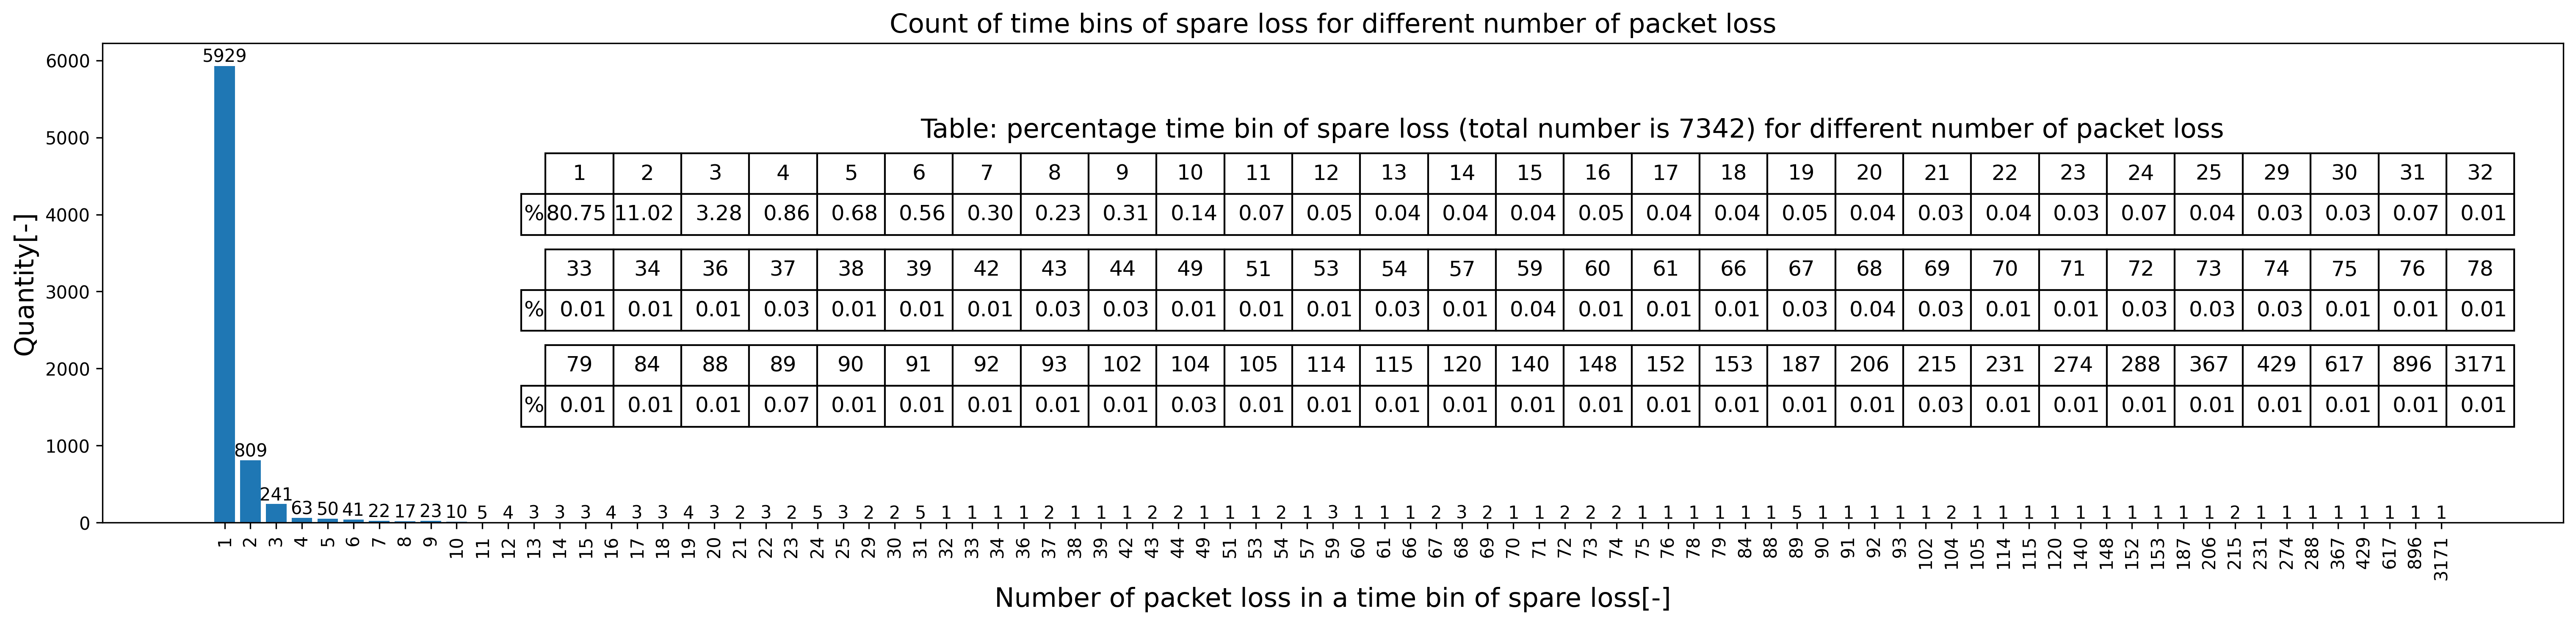

In [60]:
plt.figure(figsize=(25,5), dpi=300)
bar = plt.bar(list(range(0,len(list_counter))), list_counter.values())
i = 0
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, list(list_counter.values())[i], ha='center', va='bottom')
    i += 1
    
data = [[format(x/num_bin_sparse_loss*100, '.2f') for x in list_counter.values()]]
columns = [int(x) for x in list_counter.keys()]
rows = ['%']

table = plt.table(cellText=[data[0][0:29]], rowLabels=rows, colWidths = [0.01]*29, colLabels=columns[0:29], loc='center right', bbox = [0.18, 0.6, 0.8, 0.17])
table.scale(2.6, 1.6)                                                                                                         # bbox= [X, Y, Width, Height]
table.auto_set_font_size(False)
table.set_fontsize(12)

table = plt.table(cellText=[data[0][29:58]], rowLabels=rows, colWidths = [0.01]*29, colLabels=columns[29:58], loc='center right', bbox = [0.18, 0.4, 0.8, 0.17])
table.scale(2.6, 1.6)
table.auto_set_font_size(False)
table.set_fontsize(12)

table = plt.table(cellText=[data[0][58:87]], rowLabels=rows, colWidths = [0.01]*29, colLabels=columns[58:87], loc='center right', bbox = [0.18, 0.2, 0.8, 0.17])
table.scale(2.6, 1.6)
table.auto_set_font_size(False)
table.set_fontsize(12)

plt.text(27, 5000, f'Table: percentage time bin of spare loss (total number is {num_bin_sparse_loss}) for different number of packet loss', fontsize=15)
plt.xticks(list(range(0,len(list_counter))), [int(x) for x in list_counter.keys()], rotation=90)
plt.title('Count of time bins of spare loss for different number of packet loss', fontsize=15)
plt.xlabel('Number of packet loss in a time bin of spare loss[-]', fontsize=15)
plt.ylabel('Quantity[-]', fontsize=15)
plt.show()

In [40]:
num_packet_loss_for_concentrated_loss_list.sort()
list_counter = Counter(num_packet_loss_for_concentrated_loss_list)
list_counter_new = {}
idx = 0
rest_count = 0
for k,v in list_counter.items():
    idx += 1
    if idx <= 70:
        list_counter_new[str(int(k))] = v
    else:
        rest_count += v
list_counter_new['...'] = rest_count

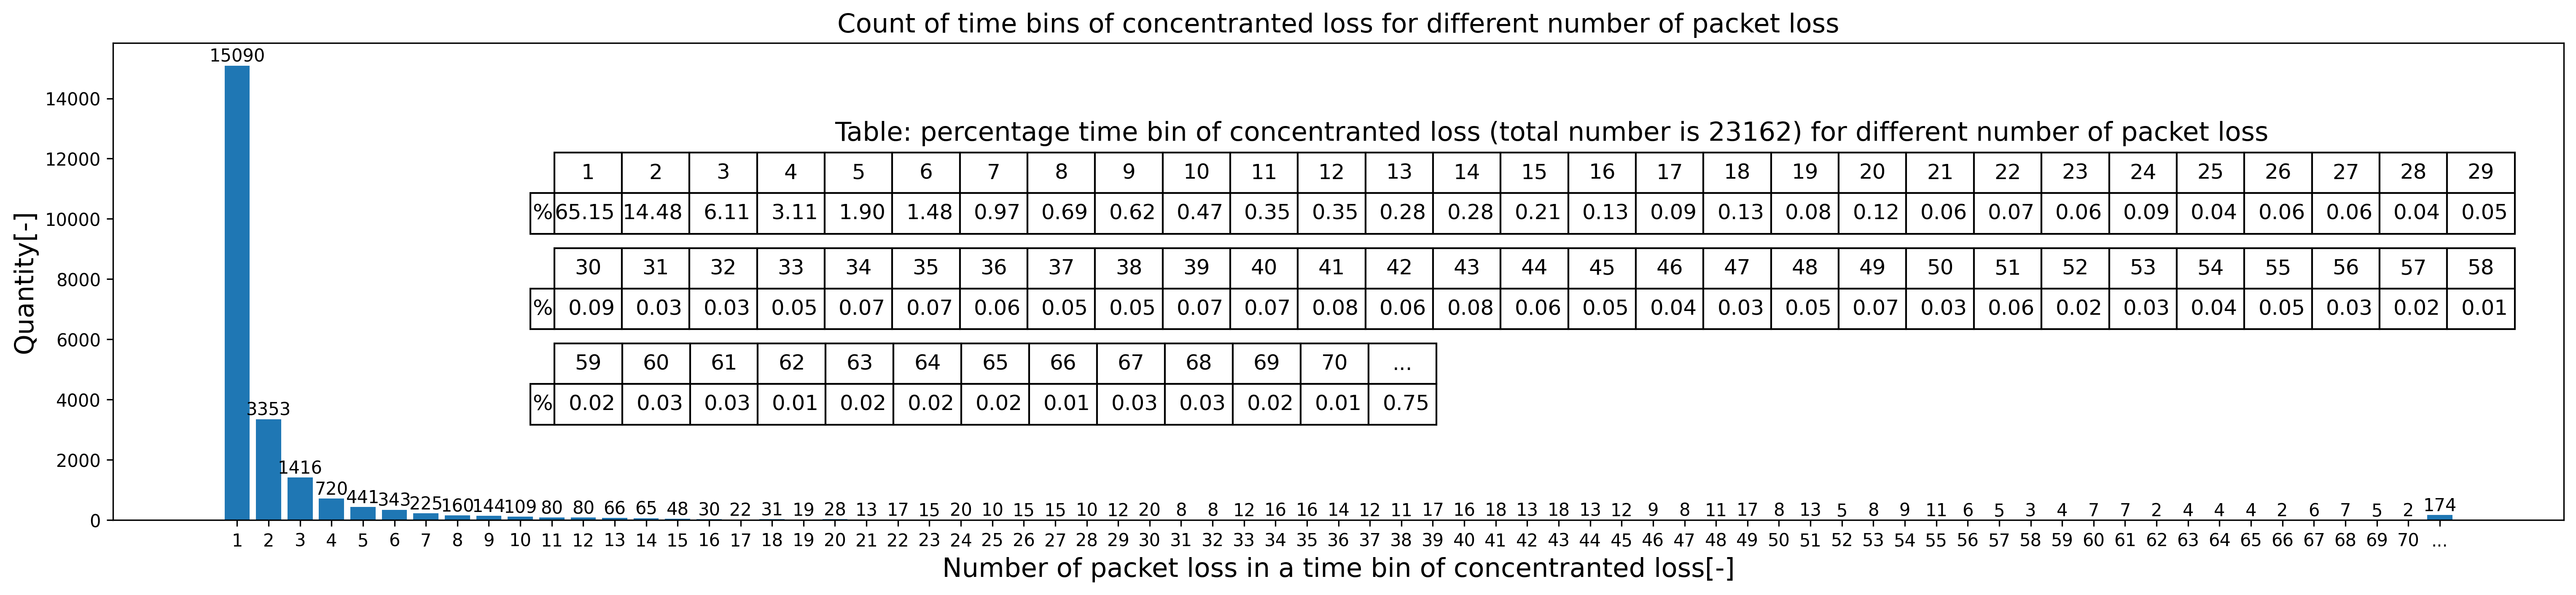

In [56]:
plt.figure(figsize=(25,5), dpi=300)
bar = plt.bar(list(range(0,len(list_counter_new))), list_counter_new.values())
i = 0
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, list(list_counter_new.values())[i], ha='center', va='bottom')
    i += 1
    
data = [[format(x/num_bin_concentranted_loss*100, '.2f') for x in list_counter_new.values()]]
columns = [x for x in list_counter_new.keys()]
rows = ['%']

table = plt.table(cellText=[data[0][0:29]], rowLabels=rows, colWidths = [0.01]*29, colLabels=columns[0:29], loc='center right', bbox = [0.18, 0.6, 0.8, 0.17])
table.scale(2.6, 1.6)                                                                                                         # bbox= [X, Y, Width, Height]
table.auto_set_font_size(False)
table.set_fontsize(12)

table = plt.table(cellText=[data[0][29:58]], rowLabels=rows, colWidths = [0.01]*29, colLabels=columns[29:58], loc='center right', bbox = [0.18, 0.4, 0.8, 0.17])
table.scale(2.6, 1.6)
table.auto_set_font_size(False)
table.set_fontsize(12)

table = plt.table(cellText=[data[0][58:71]], rowLabels=rows, colWidths = [0.01]*(71-29), colLabels=columns[58:71], loc='center right', bbox = [0.18, 0.2, 0.36, 0.17])
table.scale(2.6, 1.6)
table.auto_set_font_size(False)
table.set_fontsize(12)

plt.text(19, 12600, f'Table: percentage time bin of concentranted loss (total number is {num_bin_concentranted_loss}) for different number of packet loss', fontsize=15)
plt.xticks(list(range(0,len(list_counter_new))), [x for x in list_counter_new.keys()])
plt.title('Count of time bins of concentranted loss for different number of packet loss', fontsize=15)
plt.xlabel('Number of packet loss in a time bin of concentranted loss[-]', fontsize=15)
plt.ylabel('Quantity[-]', fontsize=15)
plt.show()

In [9]:
df_result = pd.DataFrame(result_dict)
df_result_distinct = df_result.groupby(['length_covered']).size().to_frame('count').reset_index()

In [10]:
df_result

length_covered  num_packet_loss  num_bin_loss
0                  3              2.0             2
1                  3              2.0             2
2                  3              2.0             2
3                  8              2.0             2
4                  2              2.0             2
...              ...              ...           ...
4153               6              4.0             3
4154               7              2.0             2
4155              10             26.0             8
4156              14              6.0             4
4157               6             76.0             2

[4158 rows x 3 columns]

In [11]:
df_inter = df_result_distinct.sort_values(by='count', ascending=False)
total = df_inter['count'].sum()
df_inter['percentage'] = df_inter['count'] / total *100
df_inter

length_covered  count  percentage
0                 2    533   12.818663
1                 3    390    9.379509
3                 5    312    7.503608
2                 4    281    6.758057
5                 7    274    6.589707
..              ...    ...         ...
103             155      1    0.024050
67               70      1    0.024050
105             165      1    0.024050
84               95      1    0.024050
129             739      1    0.024050

[130 rows x 3 columns]

In [12]:
print(df_inter['count'].sum(), 'aggregation of losses in total')
print(f"{df_inter.iloc[0:16]['percentage'].sum()}%") 
length_covered_list = df_inter.iloc[0:16]['length_covered'].tolist()
print('More than 80% of the length covered of aggregation of losses are with length of', length_covered_list)
print(df_inter.iloc[0:16]['percentage'].tolist())
print('max length:', df_inter['length_covered'].max()*0.5, 's')

4158 aggregation of losses in total
82.17893217893217%
More than 80% of the length covered of aggregation of losses are with length of [2, 3, 5, 4, 7, 6, 11, 8, 10, 9, 14, 12, 13, 15, 17, 18]
[12.818662818662819, 9.37950937950938, 7.503607503607504, 6.758056758056758, 6.58970658970659, 6.325156325156326, 5.6998556998557, 5.1226551226551225, 4.954304954304954, 4.617604617604617, 2.717652717652718, 2.477152477152477, 2.3328523328523327, 1.8278018278018278, 1.6354016354016354, 1.418951418951419]
max length: 369.5 s


In [13]:
color_for_plot_list = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'black', 'b', 'm', 'g', 'tab:blue', 'tab:green']

#### this is not useful, losses in aggregation is not useful since we may encounter situation like several losses in this time bin and after that, several other losses in later time bins, they are not burst of losses. If we want to know burst losses, we need to check the sequence number and losses with continuous seq num can be seen as burst of losses.
#### but since we only consider about time bin, it is useful to learn the distribution of packet loss in loss aggregation and since the quantity is small, it also prove the difficulty of prediction because even in aggregation losses, the number is still small which will dilute the impact of loss.

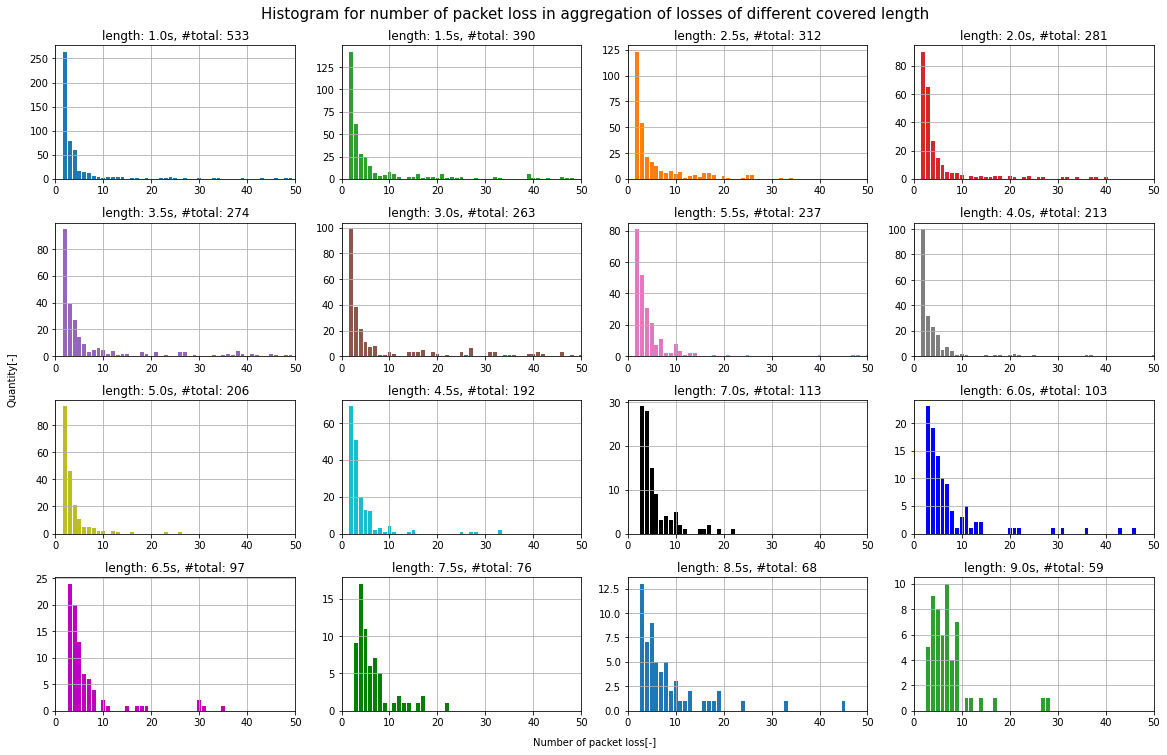

In [77]:
# for number of packet loss greater than 50, they are discraded since the quantity of them is very small

fig, axs = plt.subplots(4, 4, sharex=False, sharey=False, figsize=(16, 10))
row = 0
col = 0
color_idx = -1

for length in length_covered_list:
    color_idx += 1
    df_temp = df_result[df_result['length_covered'] == length].copy()
#     axs[row,col].hist(
#         df_temp['num_packet_loss'], 
#         bins=100, 
#         color=color_for_plot_list[color_idx]
#     )
    temp_list = df_temp['num_packet_loss'].drop_duplicates().tolist()
    temp_list.sort()
    axs[row,col].bar(temp_list, [df_temp[df_temp['num_packet_loss']==x]['num_packet_loss'].count() for x in temp_list], color=color_for_plot_list[color_idx])
    axs[row,col].grid()
    axs[row,col].set_title(f"length: {length*0.5}s, #total: {int(df_inter.iloc[color_idx]['count'])}")
    axs[row,col].set_xlim([0,50])
    col += 1
    if col == 4:
        col = 0
        row += 1

fig.text(0.5, 1, 'Histogram for number of packet loss in aggregation of losses of different covered length', ha='center', fontdict={'size':15})
fig.text(0.5, -0.01, 'Number of packet loss[-]', ha='center')
fig.text(-0.01, 0.5, 'Quantity[-]', va='center', rotation='vertical')
plt.tight_layout()
plt.show()

In [66]:
# note that the folowings are without the column of num_packet_loss

total_loss = 0
num_consecutive_loss_dict = {}
for df_separate in df_total_final:
    df_temp = copy.deepcopy(df_separate) 
    for key, df_output in df_temp.groupby((df_temp['lossOrNot'].shift() != df_temp['lossOrNot']).cumsum()):
        if df_output.iloc[0]['lossOrNot'] > 0:
            length = df_output.shape[0]
            if length in num_consecutive_loss_dict.keys():
                num_consecutive_loss_dict[length] += length
            else:
                num_consecutive_loss_dict[length] = length
            total_loss += length

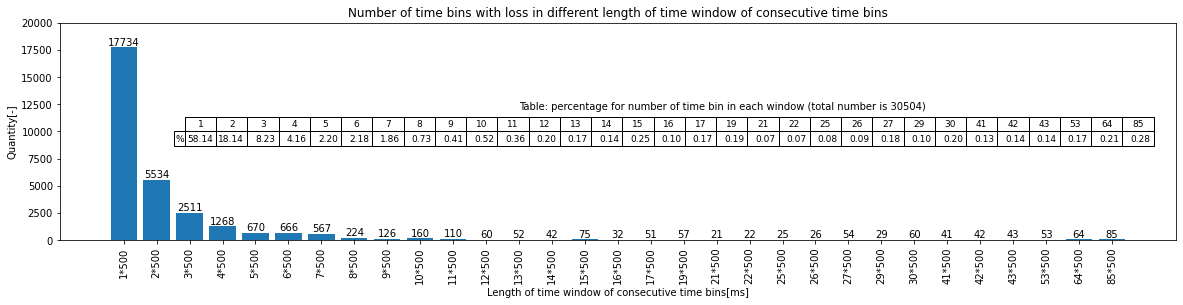

In [169]:
import collections

ordered_dict = collections.OrderedDict(sorted(num_consecutive_loss_dict.items()))

plt.figure(figsize=(20,4))
bar = plt.bar(list(range(0,len(ordered_dict))), ordered_dict.values())
i = 0
for rect in bar:
    height = rect.get_height()
    l_keys = list(ordered_dict.keys())
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, ordered_dict[l_keys[i]], ha='center', va='bottom')
#     plt.text(rect.get_x() + rect.get_width() / 2.0, height, f"{format(ordered_dict[l_keys[i]]/total_loss*100, '.2f')}%", ha='center', va='bottom')
    i += 1
data = [[format(x/total_loss*100, '.2f') for x in ordered_dict.values()]]
columns = list(ordered_dict.keys())
rows = ['%']
table = plt.table(cellText=data, rowLabels=rows, colWidths = [0.028]*31, colLabels=columns, loc='center right')
table.scale(1, 1.2)
plt.text(12, 12000, f'Table: percentage for number of time bin in each window (total number is {total_loss})')
plt.xticks(list(range(0,len(ordered_dict))), [f'{x}*500' for x in ordered_dict.keys()], rotation = 90)
plt.ylim([0,20000])
plt.title('Number of time bins with loss in different length of time window of consecutive time bins')
plt.xlabel('Length of time window of consecutive time bins[ms]')
plt.ylabel('Quantity[-]')
plt.show()

In [173]:
num_neighbour_loss = {}
for i in range(1,11):
    num_neighbour_loss[i*0.5] = 0

for df_separate in df_total_final:
    df_temp = copy.deepcopy(df_separate) 
    loss_index_list = df_temp[df_temp['lossOrNot'] > 0].index.tolist()
    
    if len(loss_index_list) > 1:
        for idx in range(0, len(loss_index_list)-1):
            diff = loss_index_list[idx+1] - loss_index_list[idx]
            if diff <= 10:
                num_neighbour_loss[diff*0.5] += 1

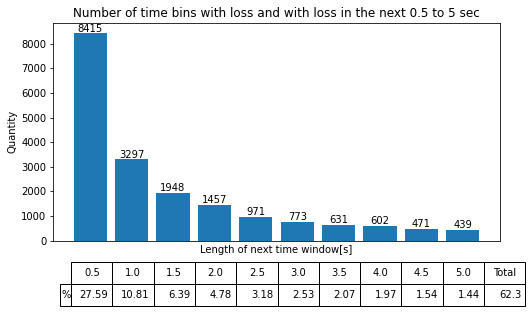

In [247]:
plt.figure(figsize=(8,4))
bar = plt.bar(list(range(0,len(num_neighbour_loss))), num_neighbour_loss.values())
i = 0
for rect in bar:
    height = rect.get_height()
    l_keys = list(num_neighbour_loss.keys())
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, num_neighbour_loss[l_keys[i]], ha='center', va='bottom')
    i += 1
data = [[format(x/total_loss*100, '.2f') for x in num_neighbour_loss.values()]]
total = 0
for datum in data[0]:
    total += float(datum)
data[0].append(str(total))
columns = list(num_neighbour_loss.keys())
columns.append('Total')
rows = ['%']
table = plt.table(cellText=data, rowLabels=rows, colWidths=[0.093]*11, colLabels=columns, loc='bottom', bbox=[0.04, -0.3, 1.017, 0.2])
table.scale(1, 1)
# plt.xticks(list(range(0,len(num_neighbour_loss))), list(num_neighbour_loss.keys()))
plt.xticks([])
plt.title('Number of time bins with loss and with loss in the next 0.5 to 5 sec')
plt.xlabel('Length of next time window[s]')
plt.ylabel('Quantity')
plt.show()

In [248]:
total_loss

30504

In [6]:
color_for_plot_list = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'black', 'b', 'm', 'g']

all_features = []
for feature in df_total_final[0].columns:
    if feature not in ['timestamp', 'lossOrNot']:
        all_features.append(feature)

In [6]:
window_size = 2 * 5 # 5sec
dist_list = [i for i in range(1, window_size+1)]
x_label_list = [f'-{500*i}ms' for i in range(1, window_size+1)]
x_label_list[0] = f'{x_label_list[0]}(loss occurs in next 500ms)'
x_label_list.reverse()
x_label_list_plus = [f'{500*i}ms' for i in range(1, 11)]
x_label_list_plus[0] = f'{x_label_list_plus[0]}(no loss in past 3s)'
x_label_list_plus[-1] = f'{x_label_list_plus[-1]}(no loss in next 3s)'

interarrival_std


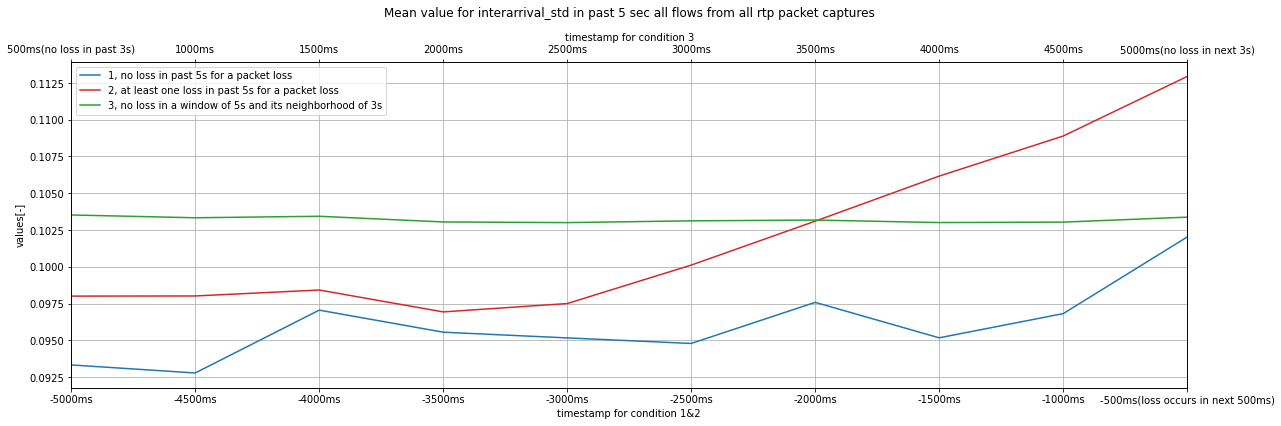

interarrival_mean


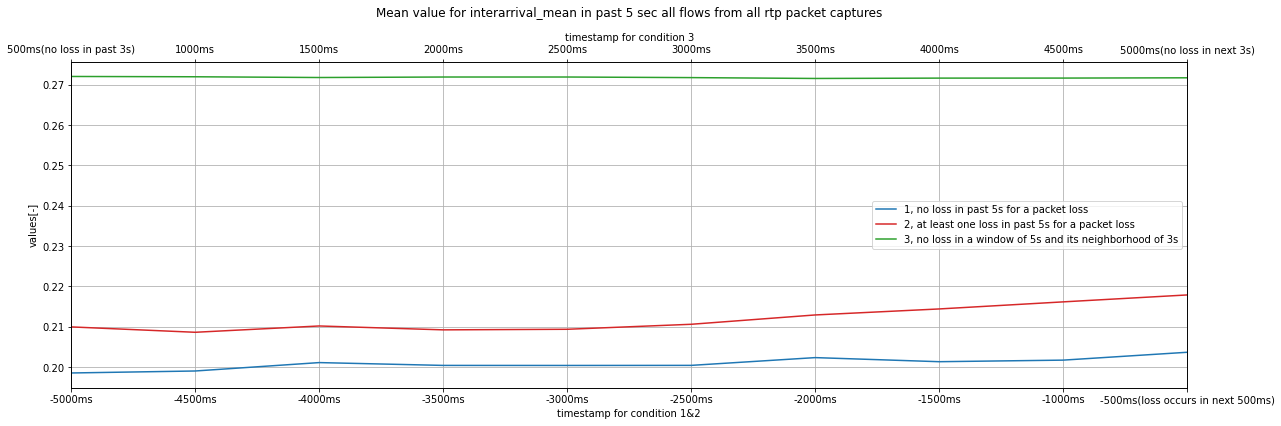

interarrival_min


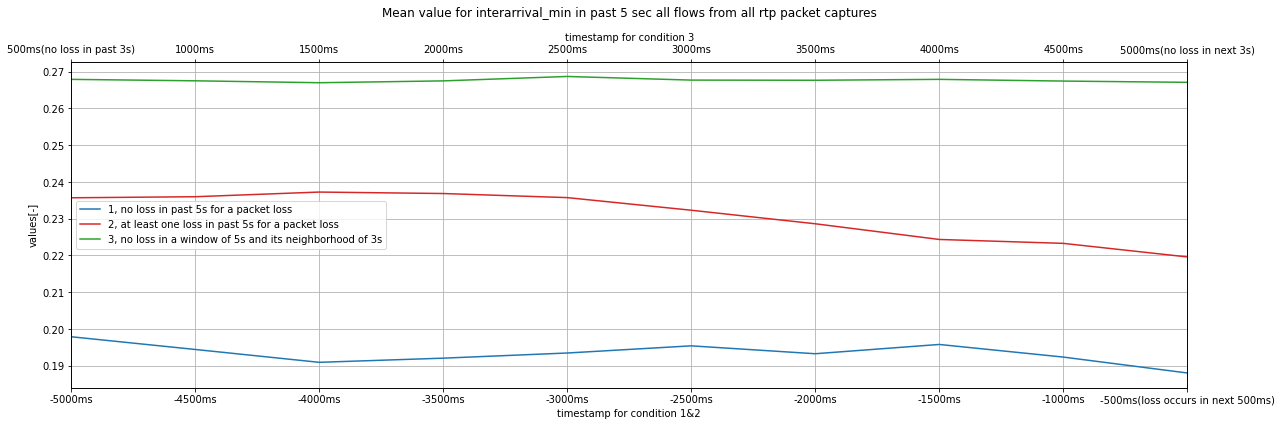

interarrival_max


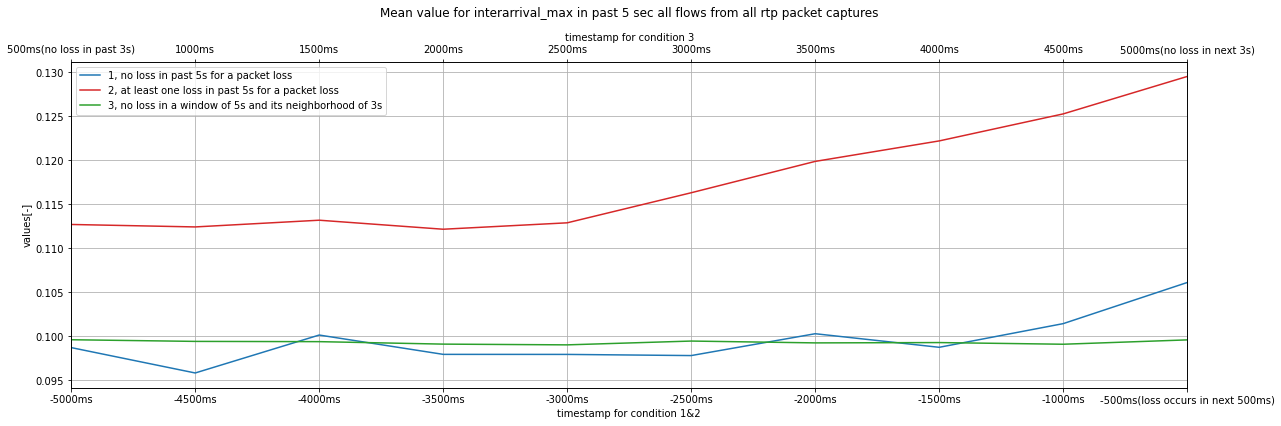

interarrival_count


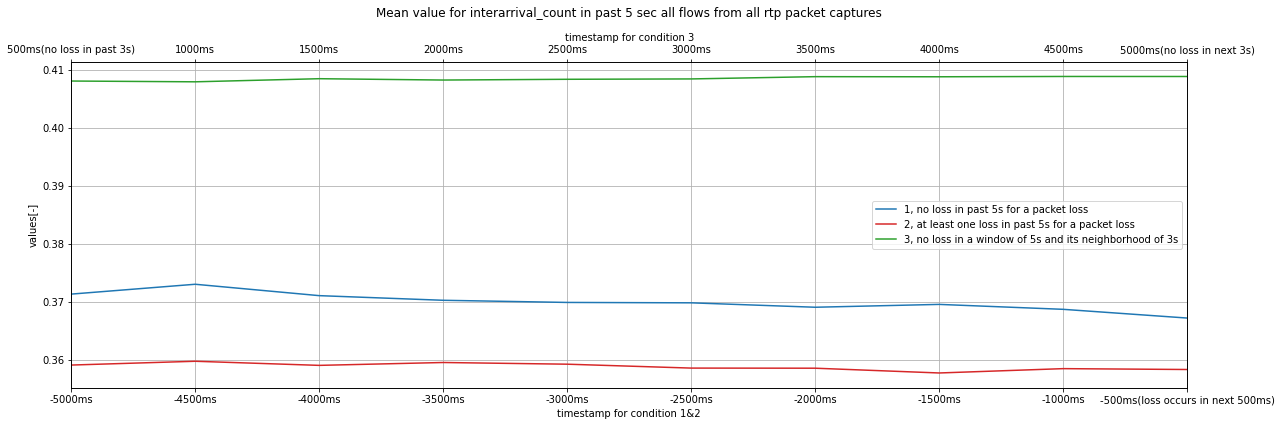

interarrival_kurtosis


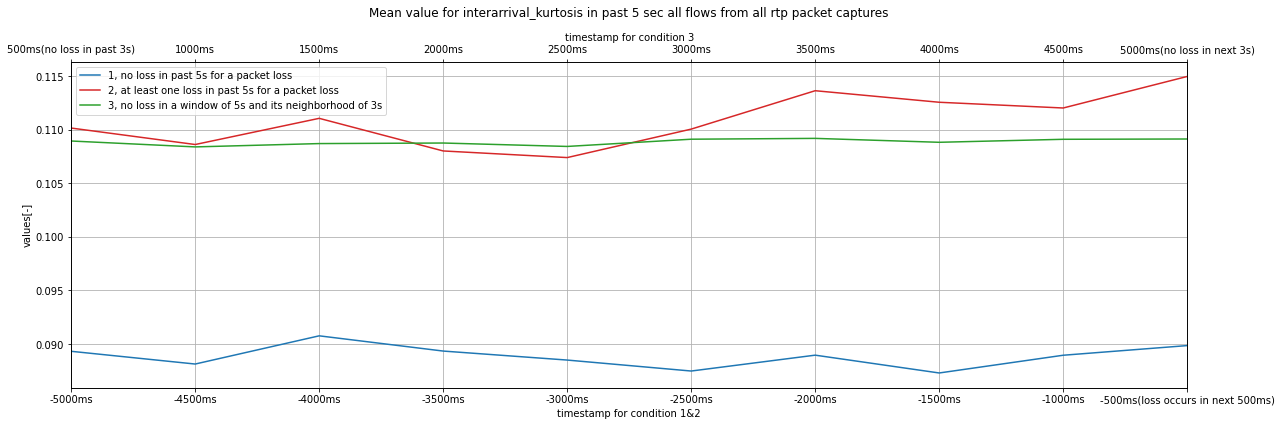

interarrival_skew


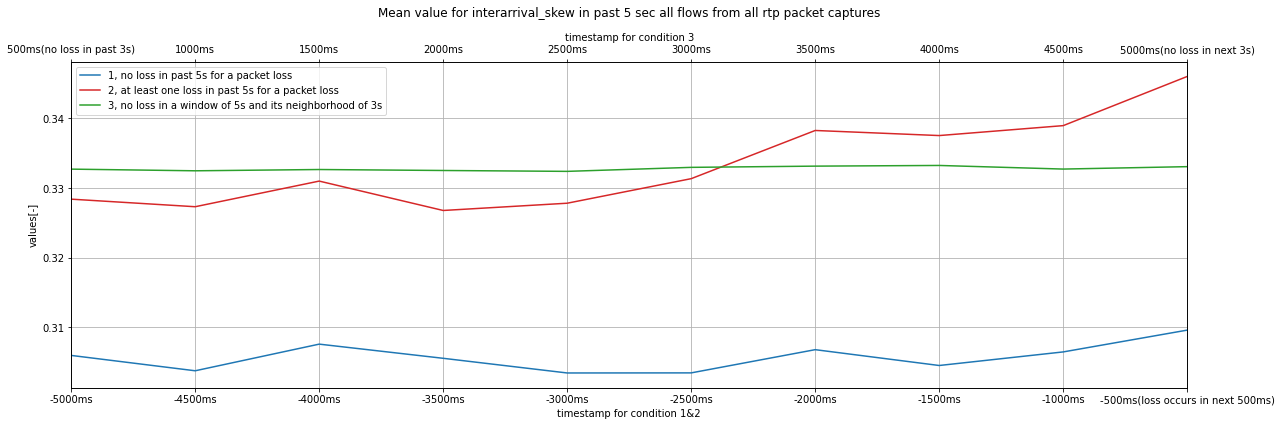

interarrival_moment3


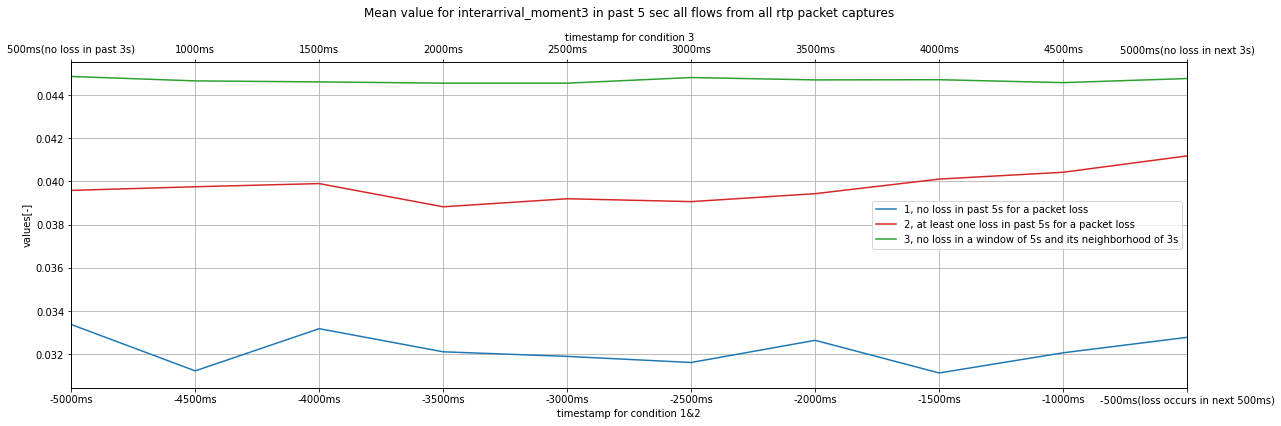

interarrival_moment4


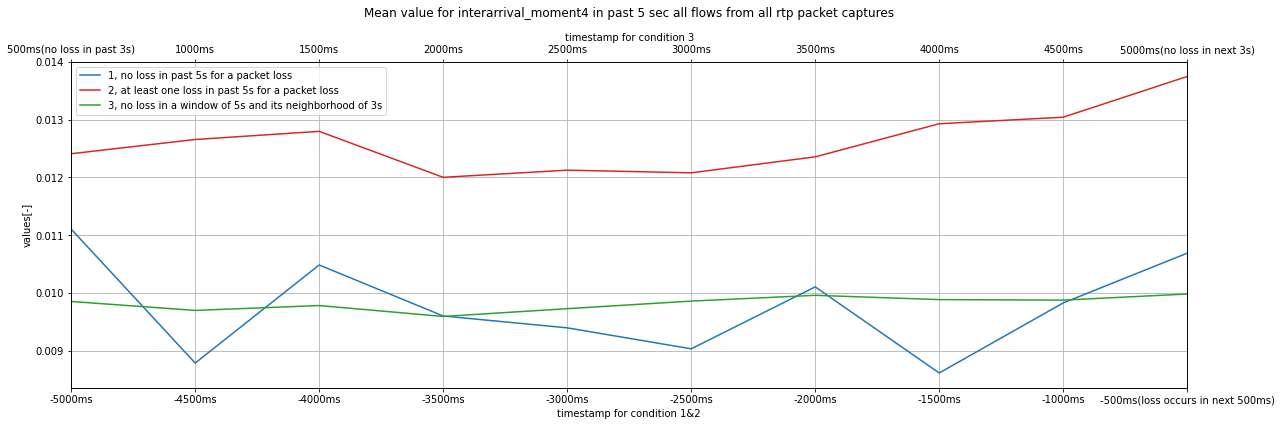

interarrival_max_min_diff


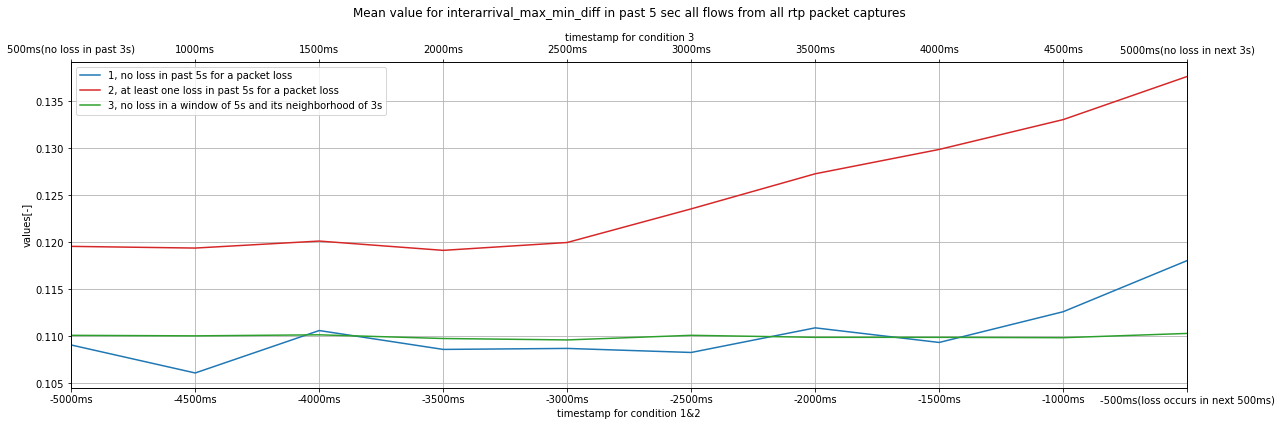

interarrival_max_min_R


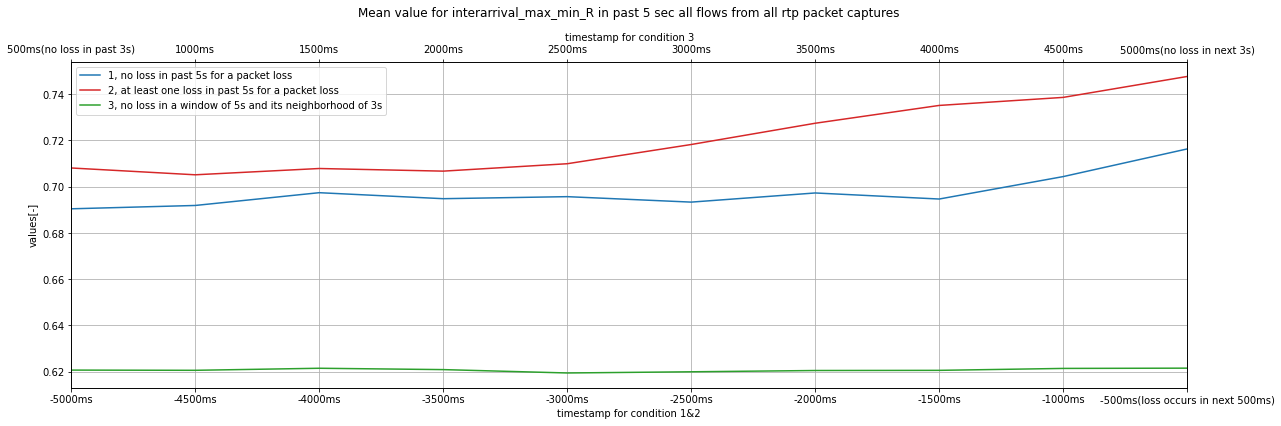

interarrival_min_max_R


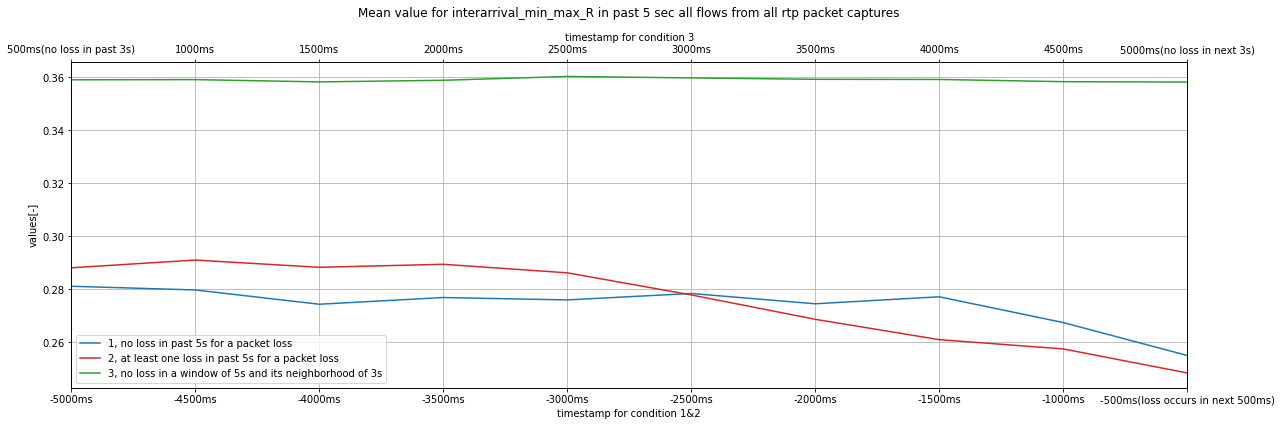

interarrival_len_unique_percent


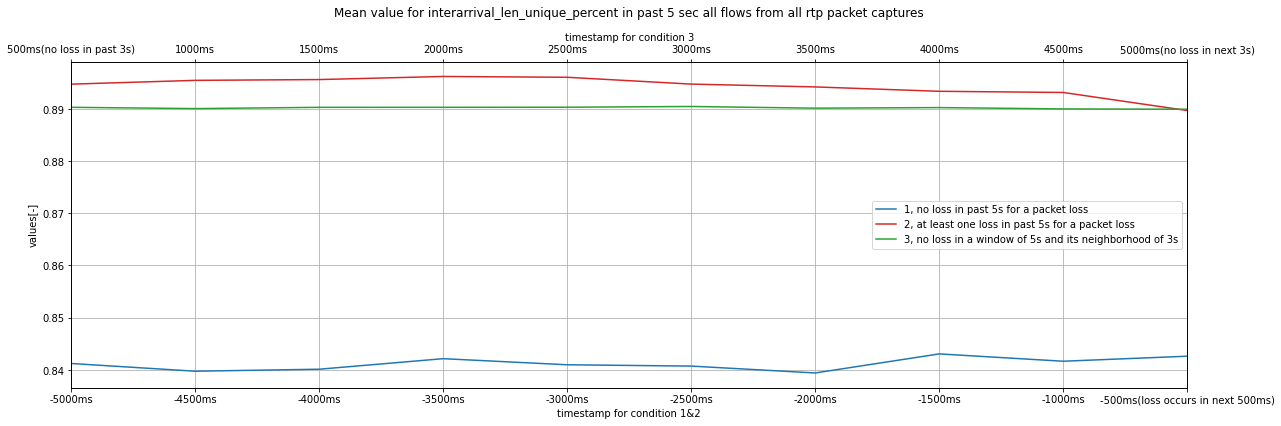

interarrival_max_value_count_percent


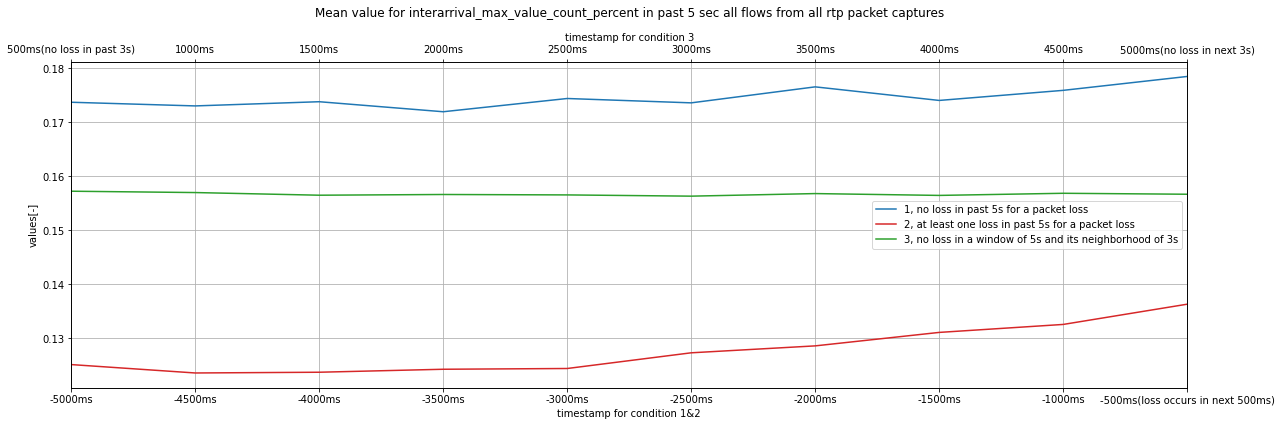

kbps


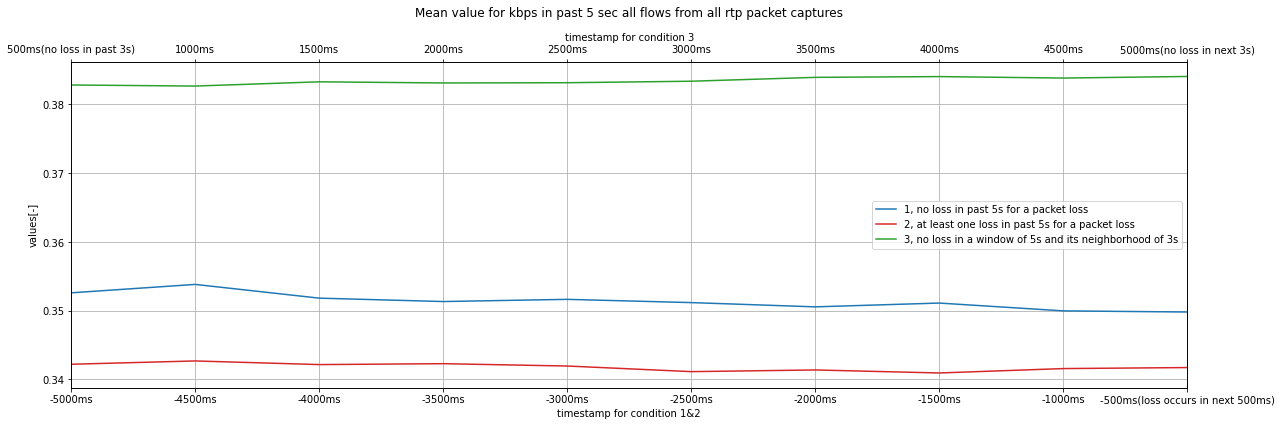

len_udp_std


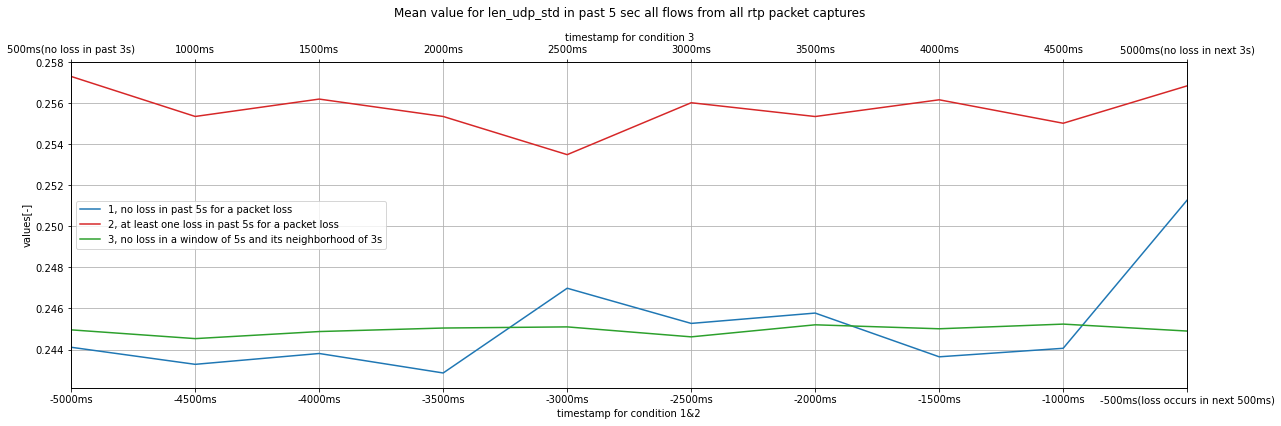

len_udp_mean


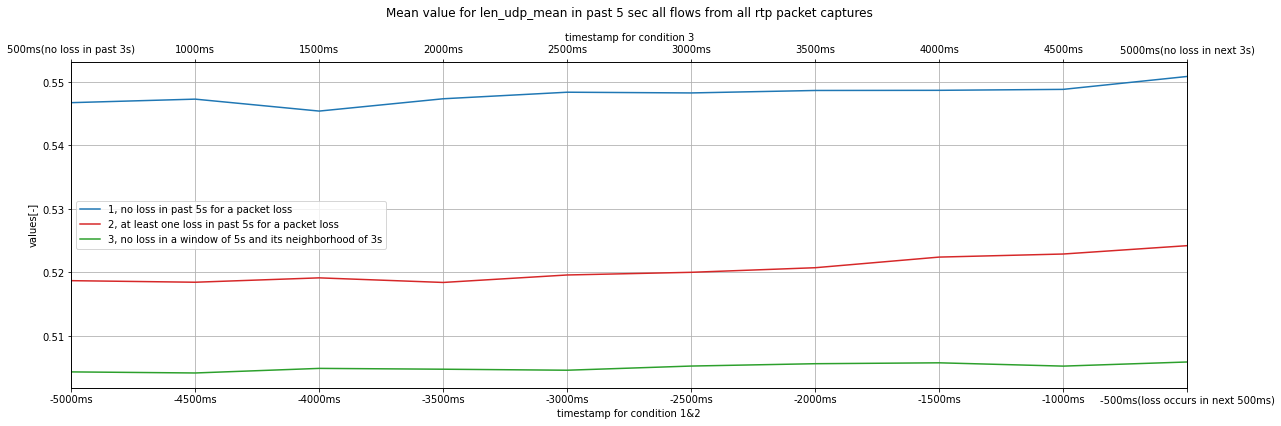

len_udp_min


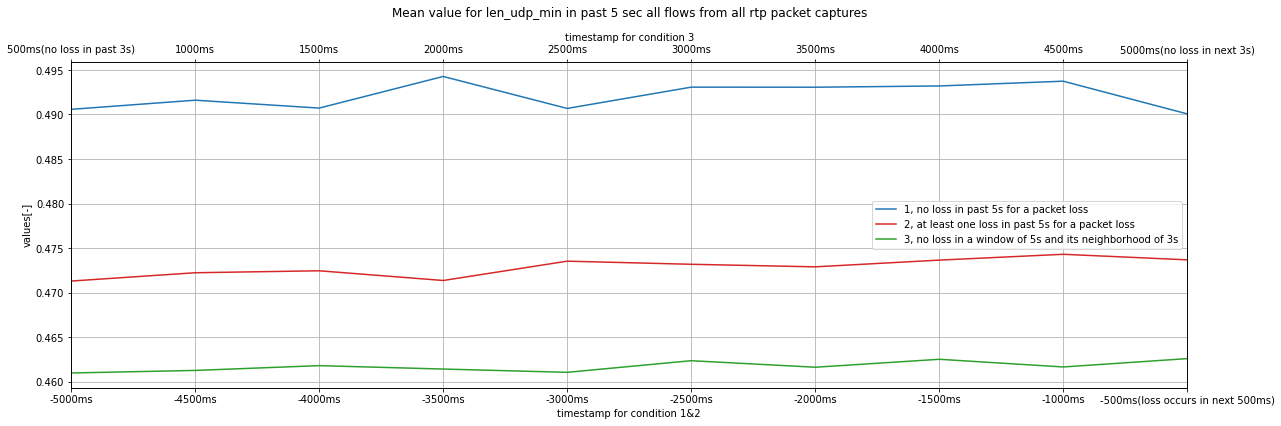

len_udp_max


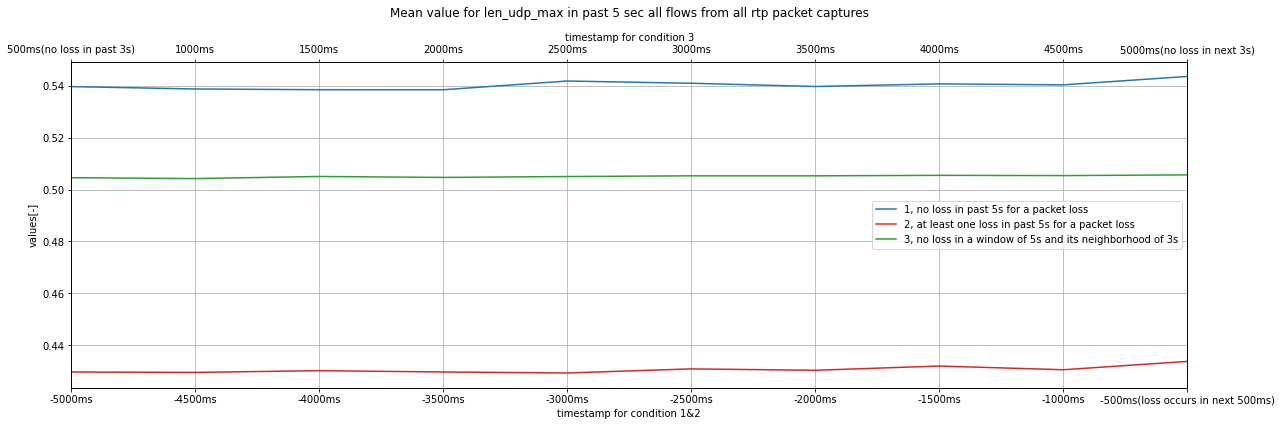

num_packets


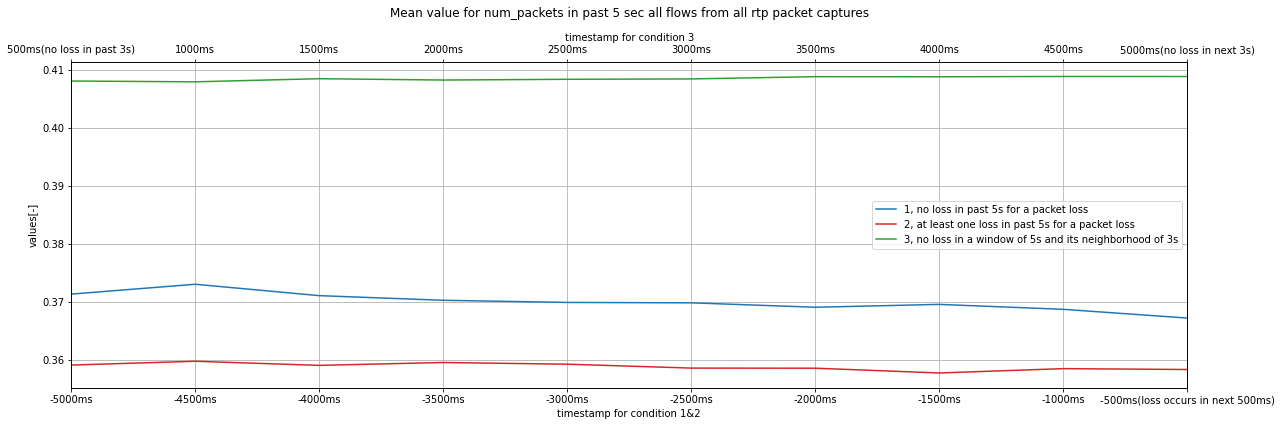

len_udp_kurtosis


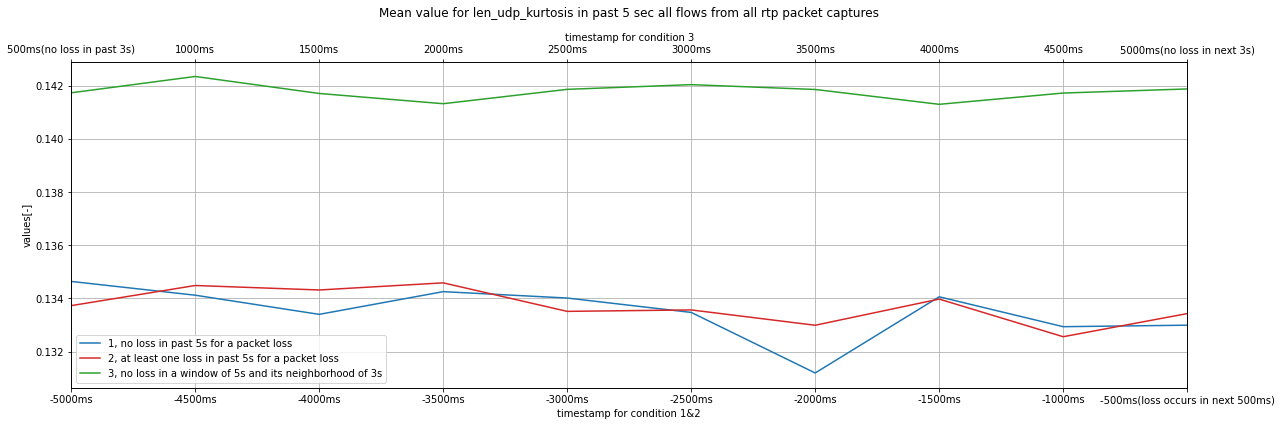

len_udp_skew


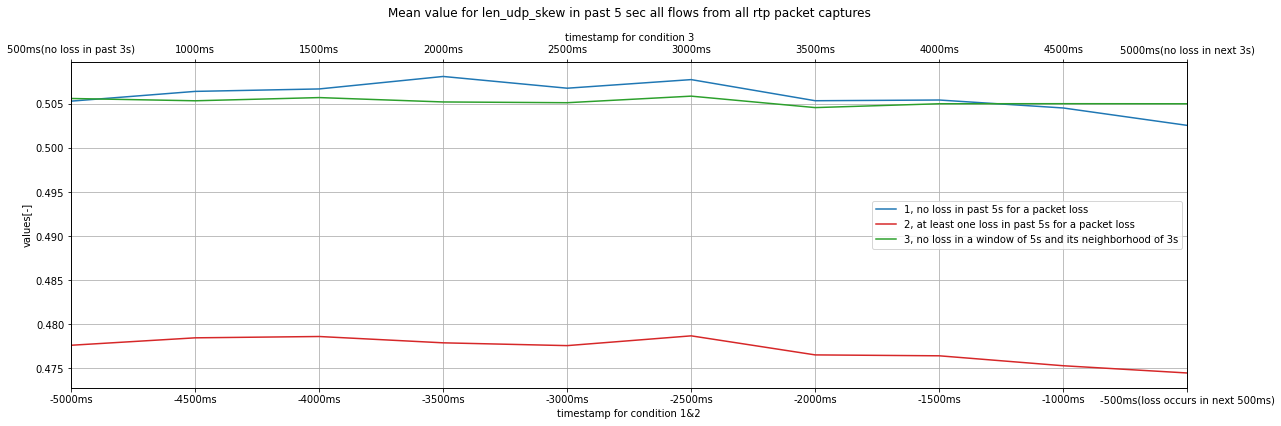

len_udp_moment3


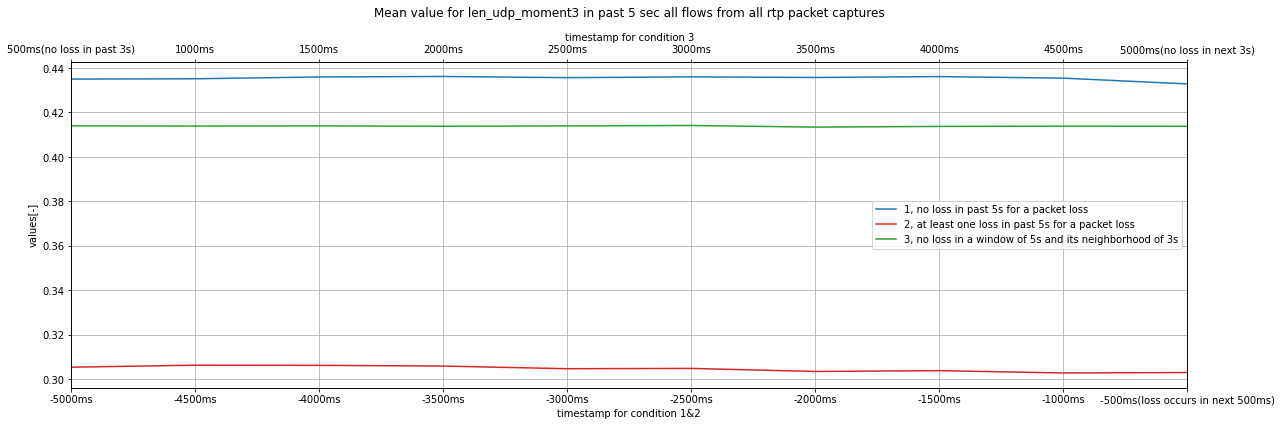

len_udp_moment4


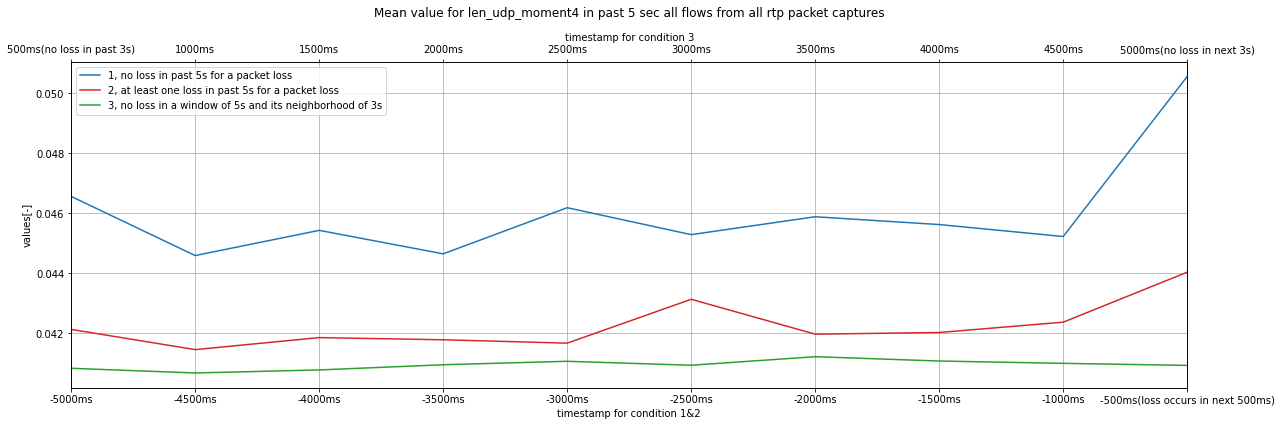

len_udp_max_min_diff


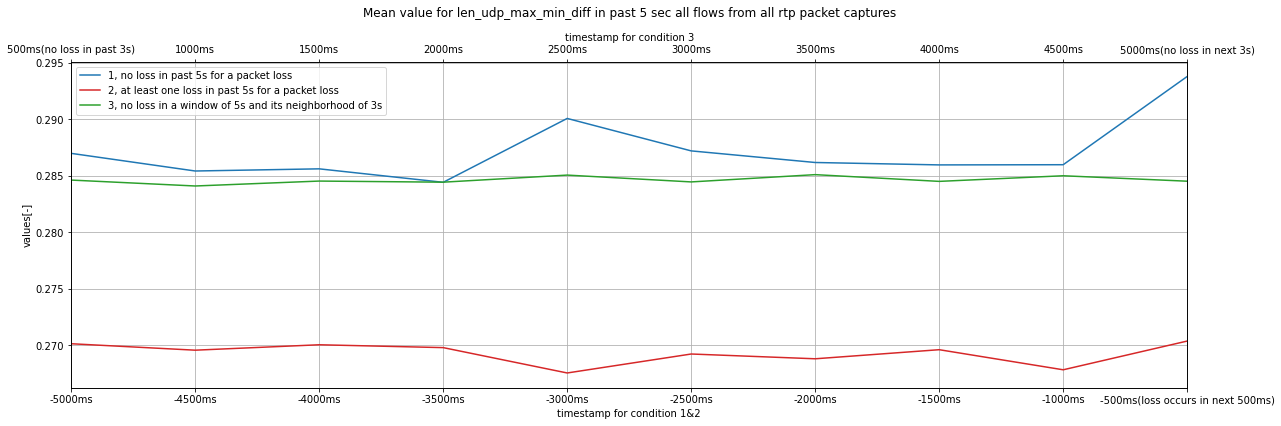

len_udp_max_min_R


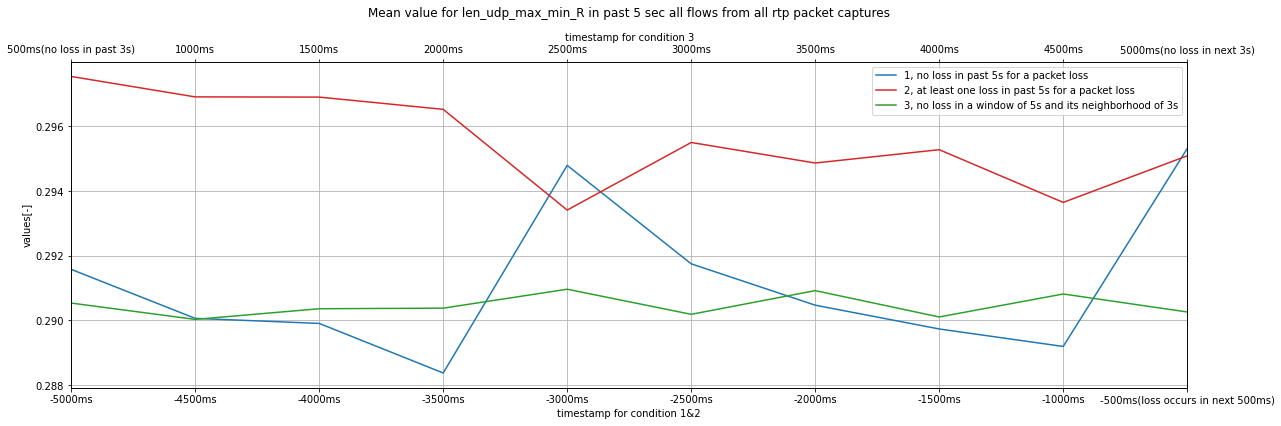

len_udp_min_max_R


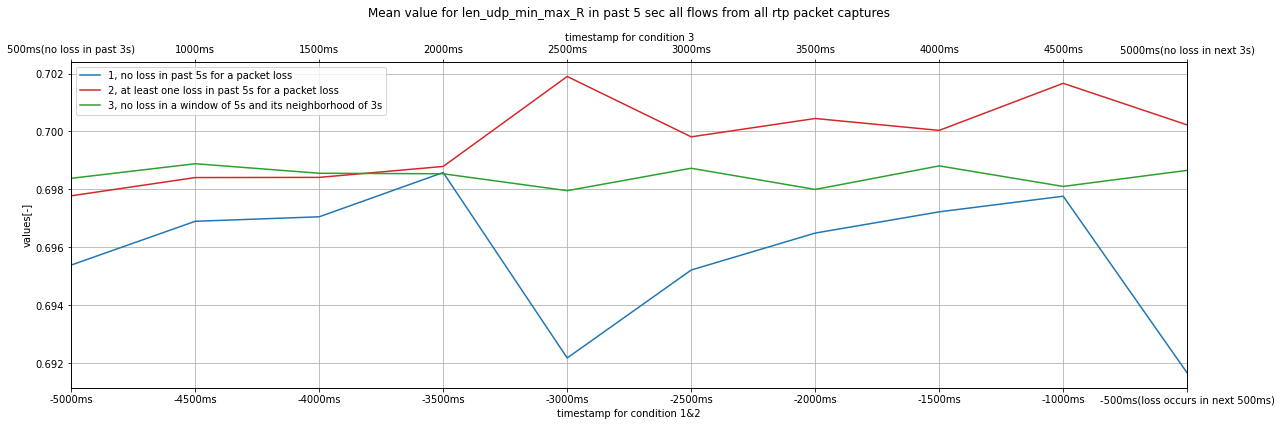

len_udp_len_unique_percent


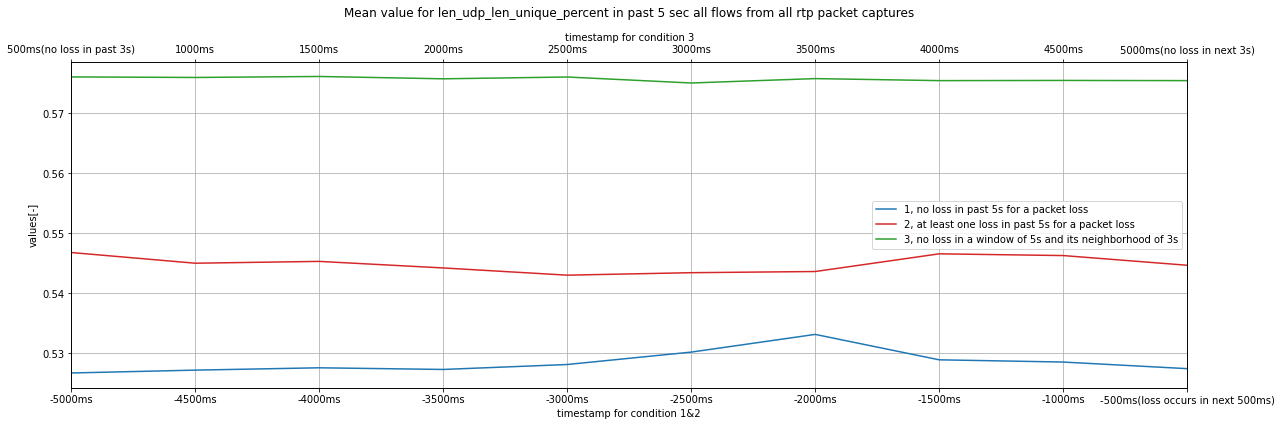

len_udp_max_value_count_percent


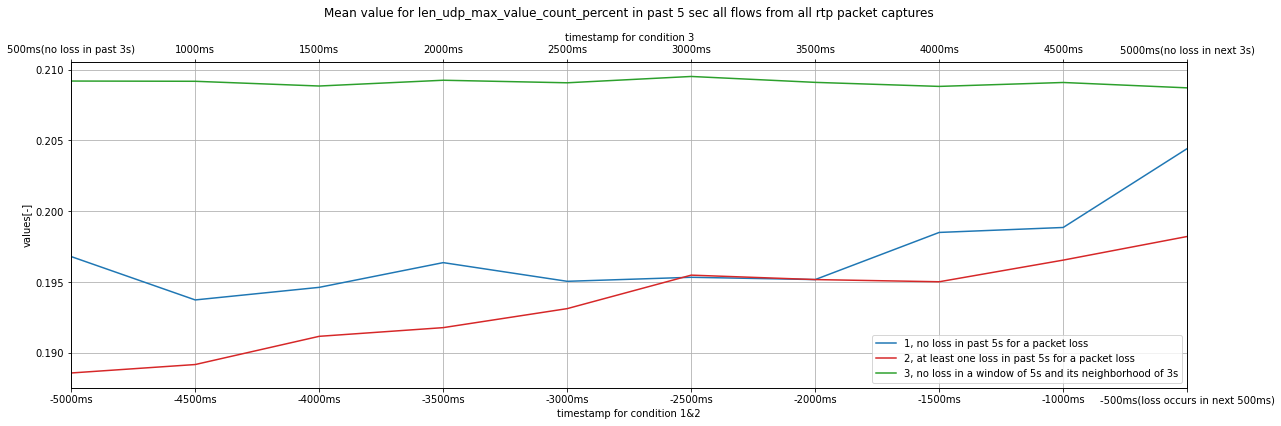

interlength_udp_std


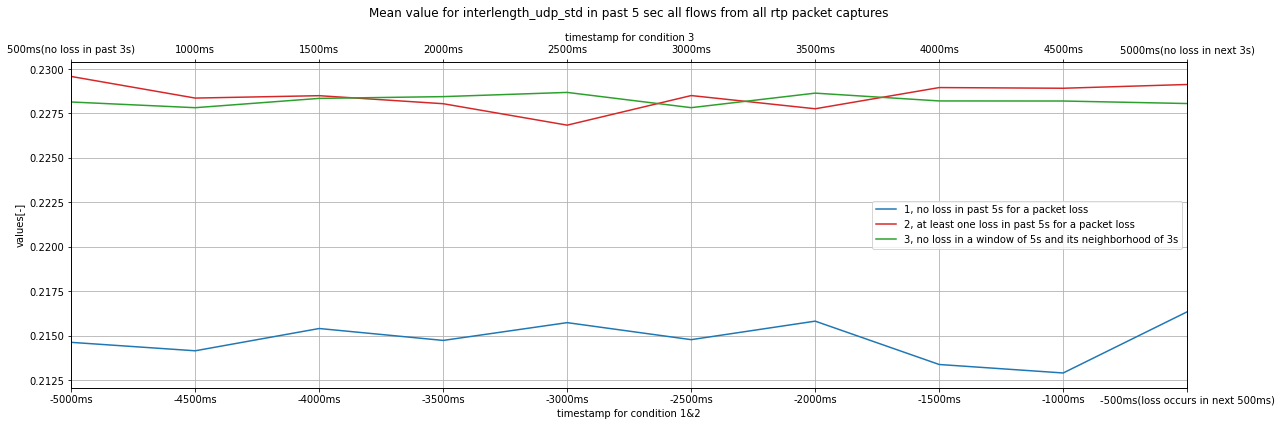

interlength_udp_mean


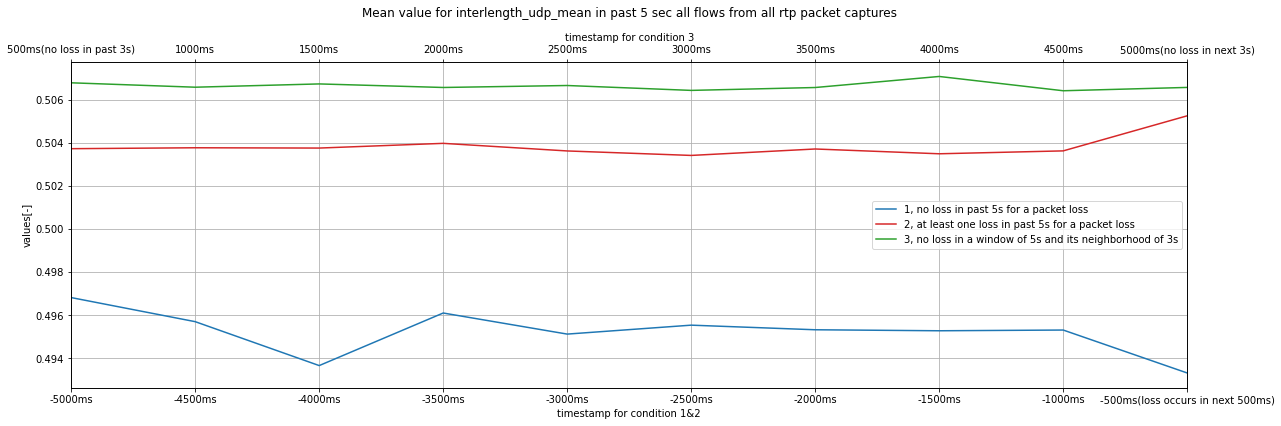

interlength_udp_min


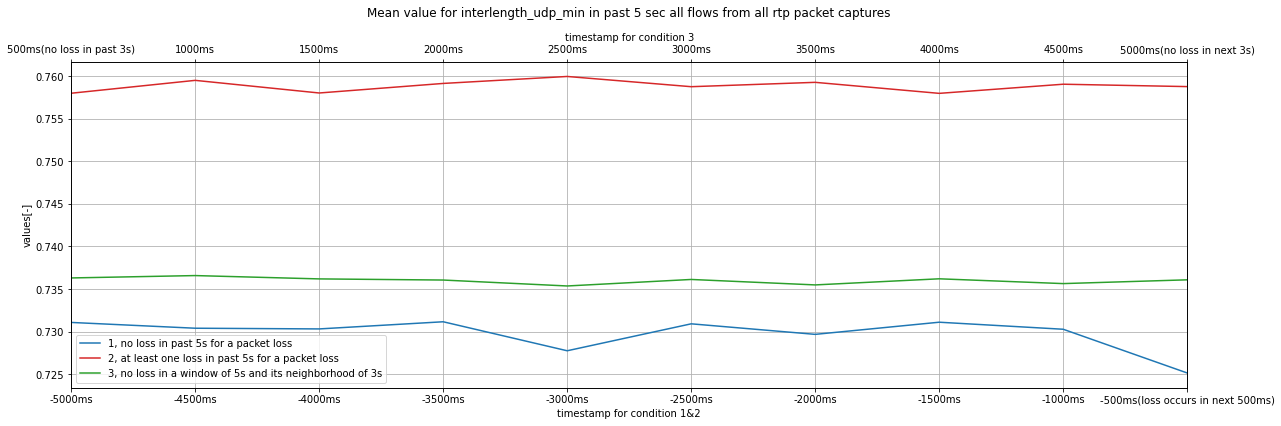

interlength_udp_max


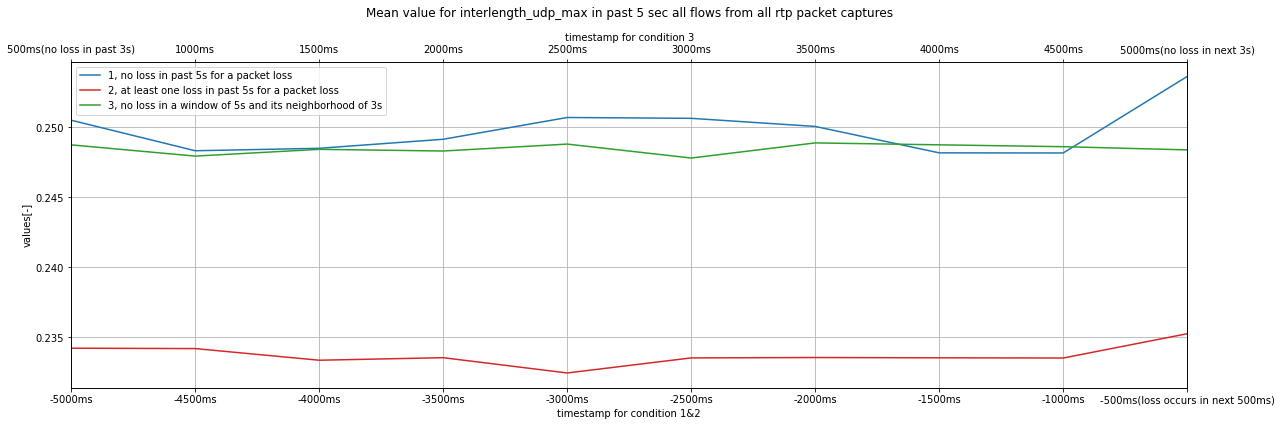

interlength_udp_count


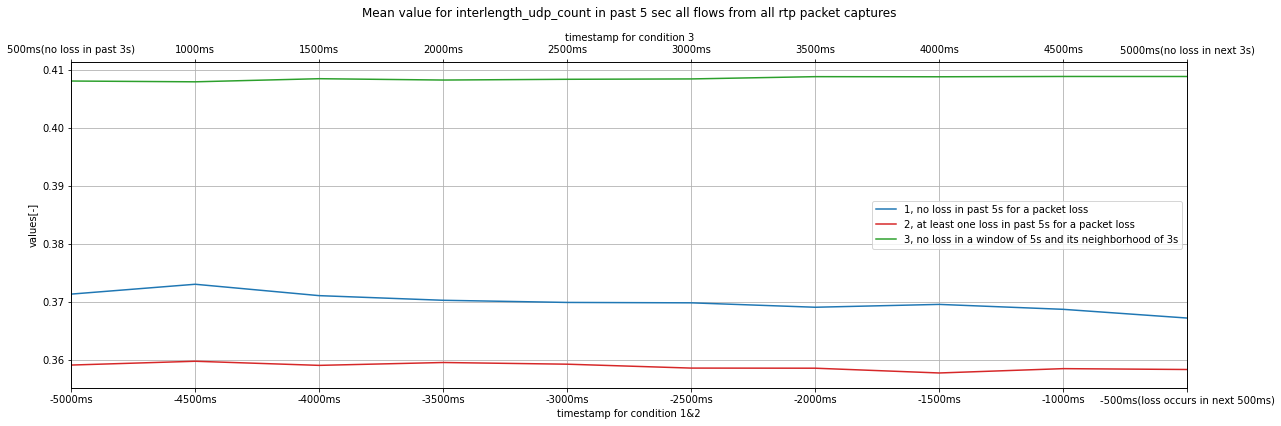

interlength_udp_kurtosis


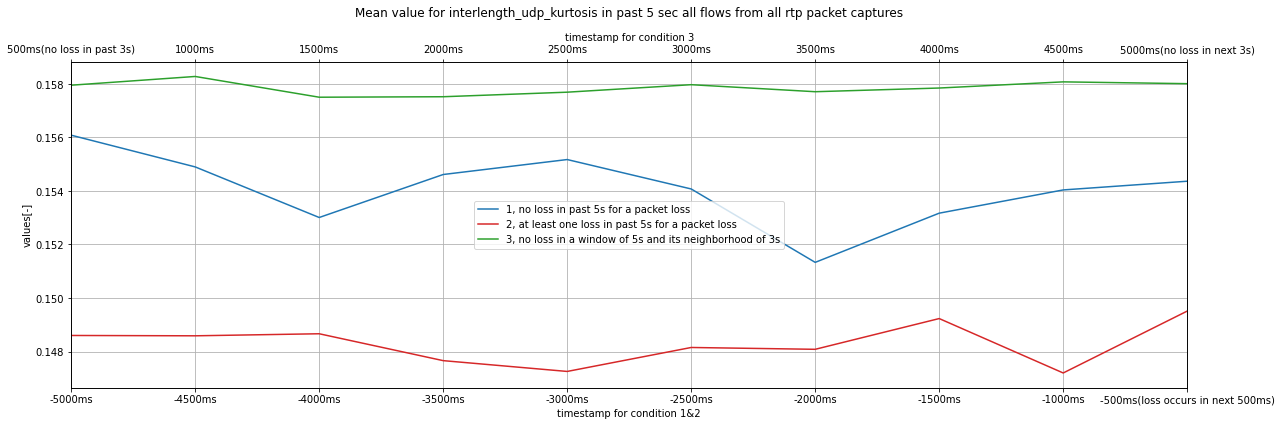

interlength_udp_skew


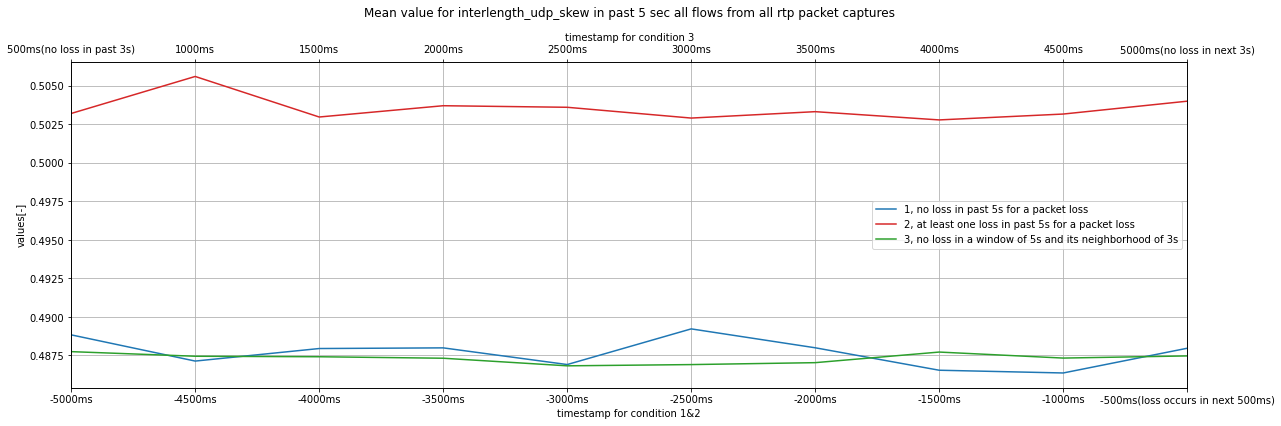

interlength_udp_moment3


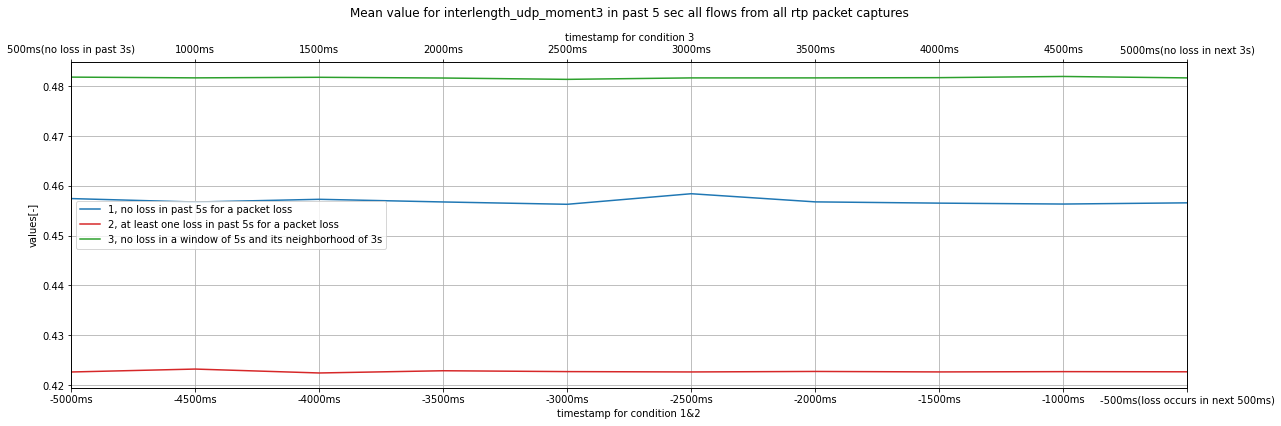

interlength_udp_moment4


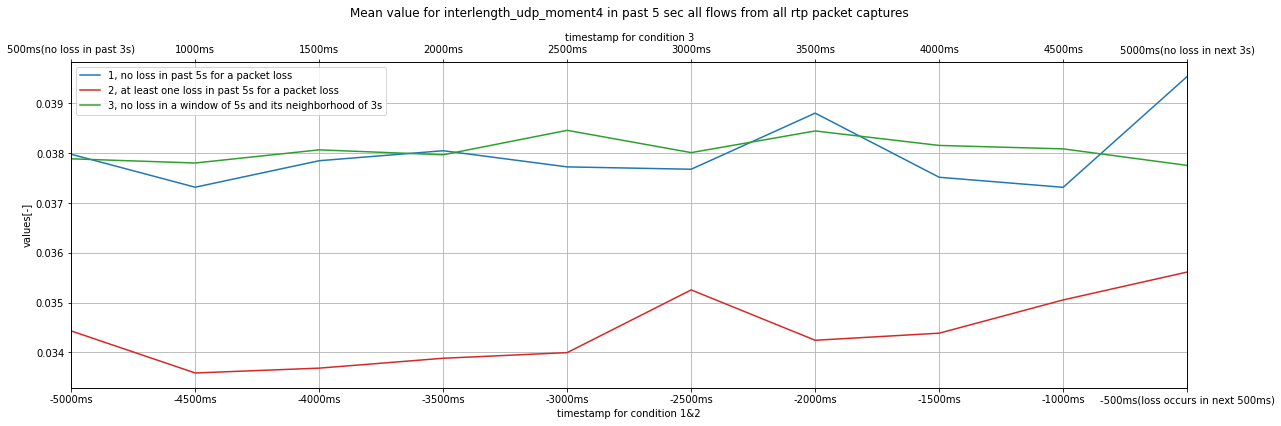

interlength_udp_max_min_diff


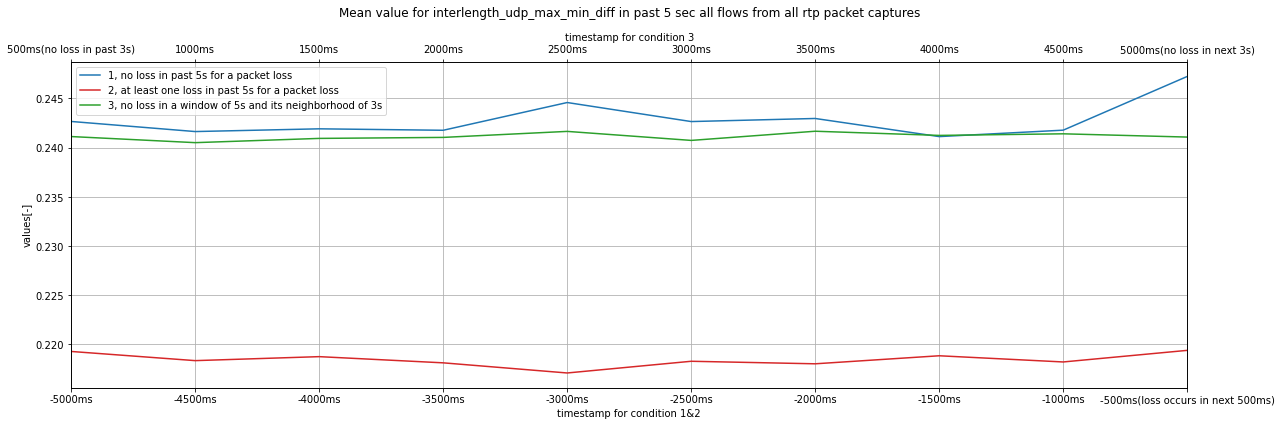

interlength_udp_max_min_R


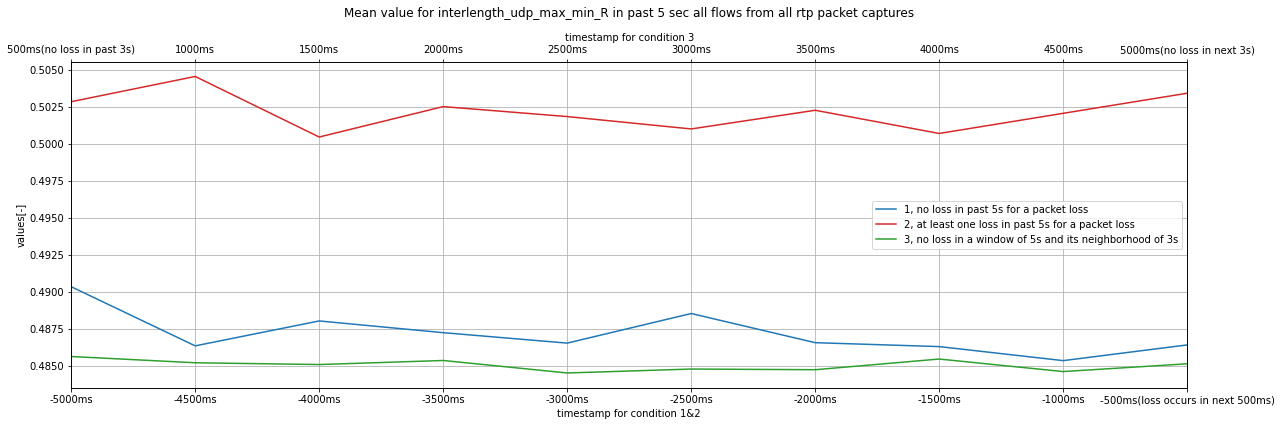

interlength_udp_min_max_R


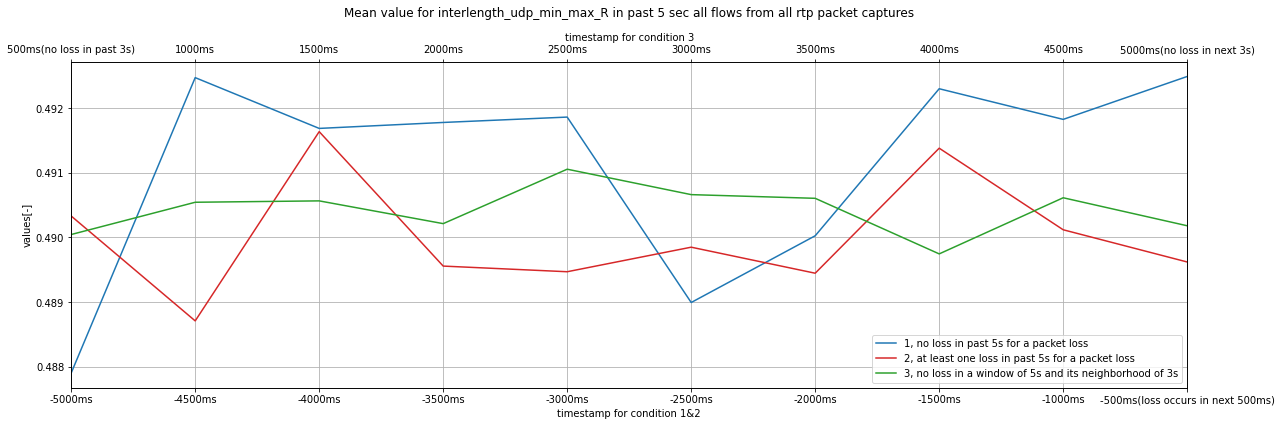

interlength_udp_len_unique_percent


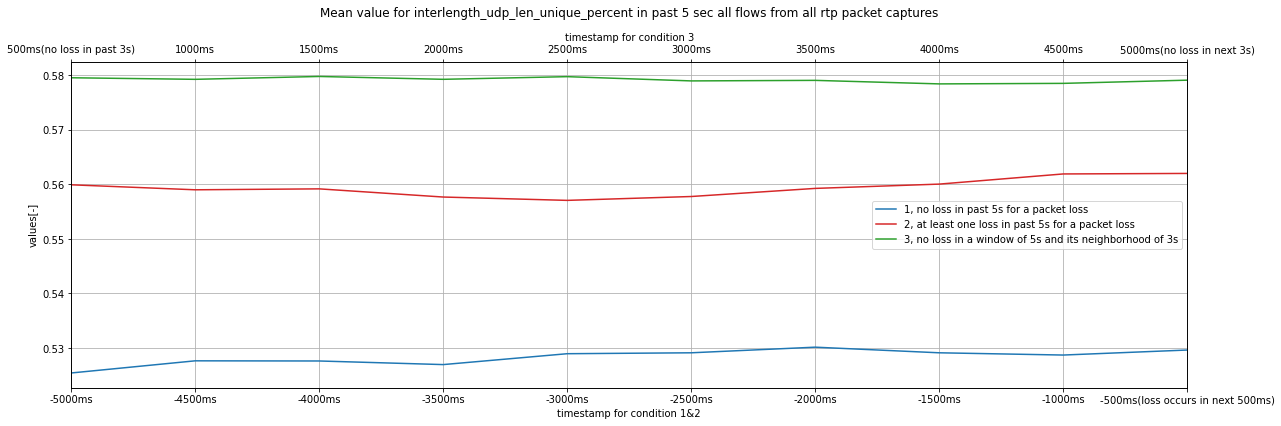

interlength_udp_max_value_count_percent


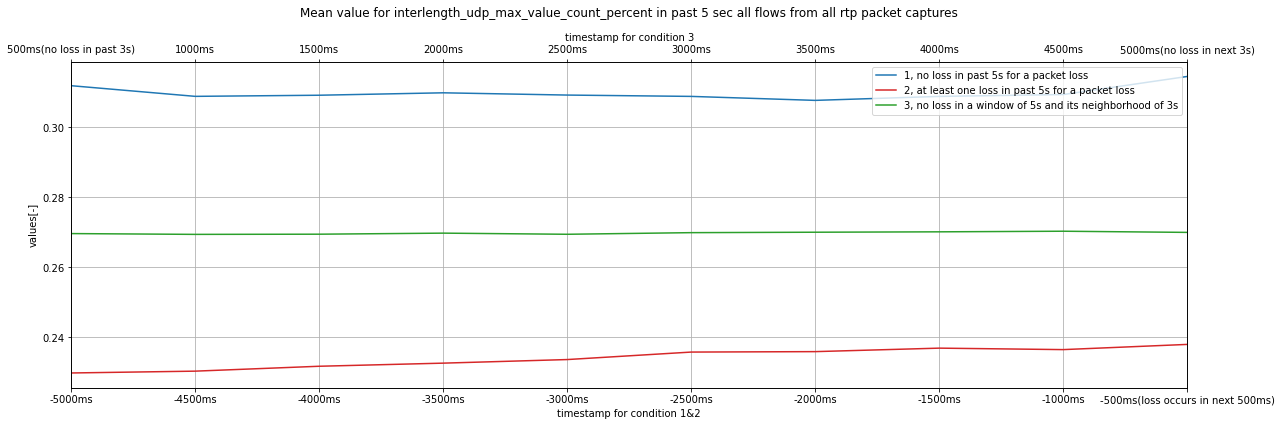

rtp_inter_timestamp_num_zeros


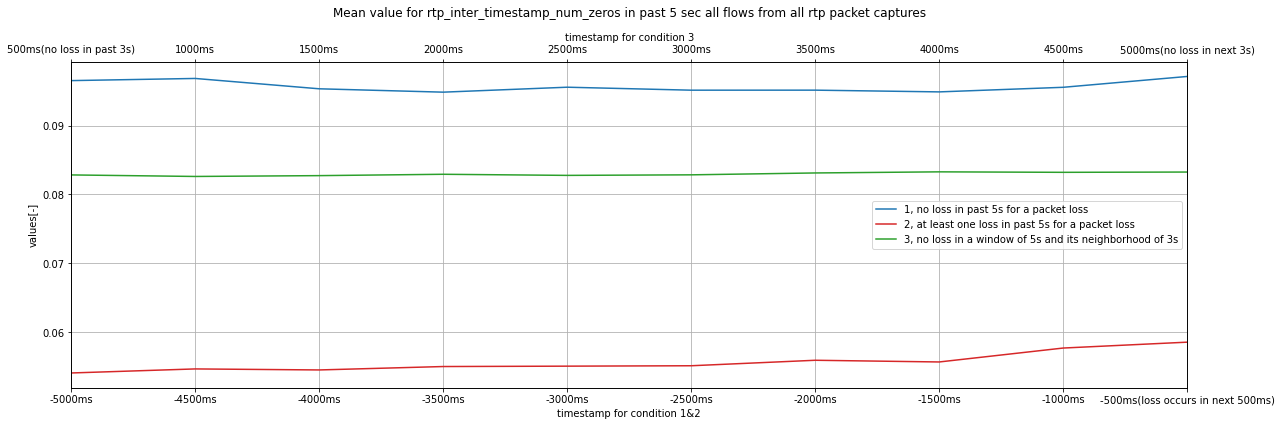

rtp_inter_timestamp_std


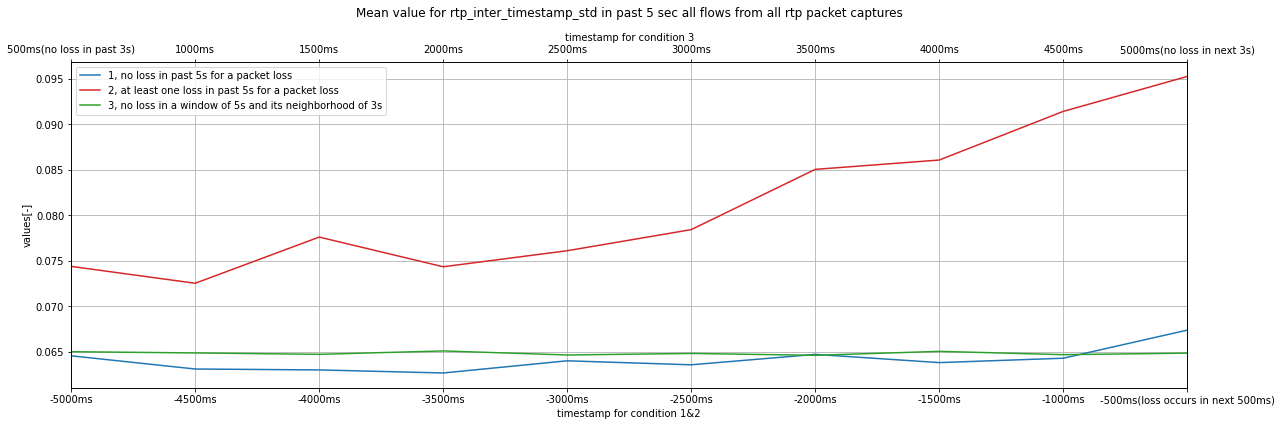

rtp_inter_timestamp_mean


In [ ]:
# check the trending of certain feature in 5s
# condition 1: no loss in past 5s for a loss;
# condition 2: at least one loss in past 5s for a loss;
# condition 3: consecutive 5s with no loss and in its neighborhood of 3s, there's also no loss.

for feature in all_features:
    print(feature)
    
    result_1 = {} # condition 1
    result_2 = {} # condition 2
    result_3 = {} # condition 3
    for i in range(window_size, 0, -1):
        result_1[str(i)] = []
        result_2[str(i)] = []
        result_3[str(i)] = []
        
    for df_ in df_total_final:
        df_temp = copy.deepcopy(df_)
        loss_index_list = df_temp[df_temp['lossOrNot'] > 0].index
        loss_index_list = [x for x in loss_index_list if x>9] # if the first loss is within the first 5s, we can only use it as feature but not output
        
        # condition 1 and 2:
        if len(loss_index_list) != 0:
            loss_index_list_no_consecutive = []
            loss_index_list_with_consecutive = []
            
            # if there are more than 1 losses
            if len(loss_index_list) > 1:
                for i in range(len(loss_index_list)-1, 0, -1):
                    if (loss_index_list[i] - loss_index_list[i-1]) not in dist_list:
                        loss_index_list_no_consecutive.append(loss_index_list[i])
                    elif (loss_index_list[i] - loss_index_list[i-1]) in dist_list:
                        loss_index_list_with_consecutive.append(loss_index_list[i])
                loss_index_list_no_consecutive.append(loss_index_list[0])
                
            # if there's only one loss, put it directly into loss_index_list_no_consecutive
            else:
                loss_index_list_no_consecutive.append(loss_index_list[0])

            for i in range(window_size, 0, -1):
                values_1 = df_temp.iloc[[x - i for x in loss_index_list_no_consecutive]][feature].tolist()
                result_1[str(i)].extend(values_1)
                values_2 = df_temp.iloc[[x - i for x in loss_index_list_with_consecutive]][feature].tolist()
                result_2[str(i)].extend(values_2)
                
        # condition 3:
        if df_temp.shape[0] >= 22: 
            for key, df_output in df_temp.groupby((df_temp['lossOrNot'].shift() != df_temp['lossOrNot']).cumsum()):
                df_output.reset_index(inplace=True)
                if df_output.iloc[0]['lossOrNot'] < 1 and df_output.shape[0] >= 22:
                    df_output = df_output.iloc[6:-6][:]
                    df_seg_list = [df_output.iloc[n:n+10, :] for n in range(0, len(df_output), 10)]
                    for df_seg in df_seg_list:
                        if df_seg.shape[0] == 10:
                            df_seg.reset_index(inplace=True)
                            for i in range(1,11):
                                result_3[str(i)].append(df_seg.iloc[i-1][feature])
                
    output_mean_1 = []
    output_std_1 = []
    output_mean_2 = []
    output_std_2 = []
    output_mean_3 = []
    output_std_3 = []
    for i in range(window_size, 0, -1):
        
        # result of condition 1
        temp = np.array(result_1[str(i)])
        temp = temp[~np.isnan(temp)]
        output_mean_1.append(temp.mean())
        output_std_1.append(np.std(temp))
        
        # result of condition 2
        temp = np.array(result_2[str(i)])
        temp = temp[~np.isnan(temp)]
        output_mean_2.append(temp.mean())
        output_std_2.append(np.std(temp))
        
        # result of condition 3
        temp = np.array(result_3[str(i)])
        temp = temp[~np.isnan(temp)]
        output_mean_3.append(temp.mean())
        output_std_3.append(np.std(temp))
        
    # visulization
    fig, axs = plt.subplots(1, figsize=(20,6), sharex=True)
    plt.title(f'Mean value for {feature} in past {int(window_size/2)} sec all flows from all rtp packet captures', y=1.12)
    axs.plot(x_label_list, output_mean_1, color=color_for_plot_list[0], label='1, no loss in past 5s for a packet loss')
    axs.plot(x_label_list, output_mean_2, color=color_for_plot_list[3], label='2, at least one loss in past 5s for a packet loss')
    axs.plot(x_label_list, output_mean_3, color=color_for_plot_list[1], label='3, no loss in a window of 5s and its neighborhood of 3s')
    axs.grid()
    axs.set_xlim(0, window_size-1)
    axs.legend()
    axs.set_xlabel('timestamp for condition 1&2')
    axs.set_ylabel('values[-]')
    axs2 = axs.twiny()
    axs2.set_xticks(axs.get_xticks())
    axs2.set_xbound(axs.get_xbound())
    axs2.set_xticklabels(x_label_list_plus)
    axs2.set_xlabel('timestamp for condition 3')
    plt.savefig(f'plots/{feature}.png', bbox_inches='tight')
    plt.show()

rtp_inter_timestamp_mean


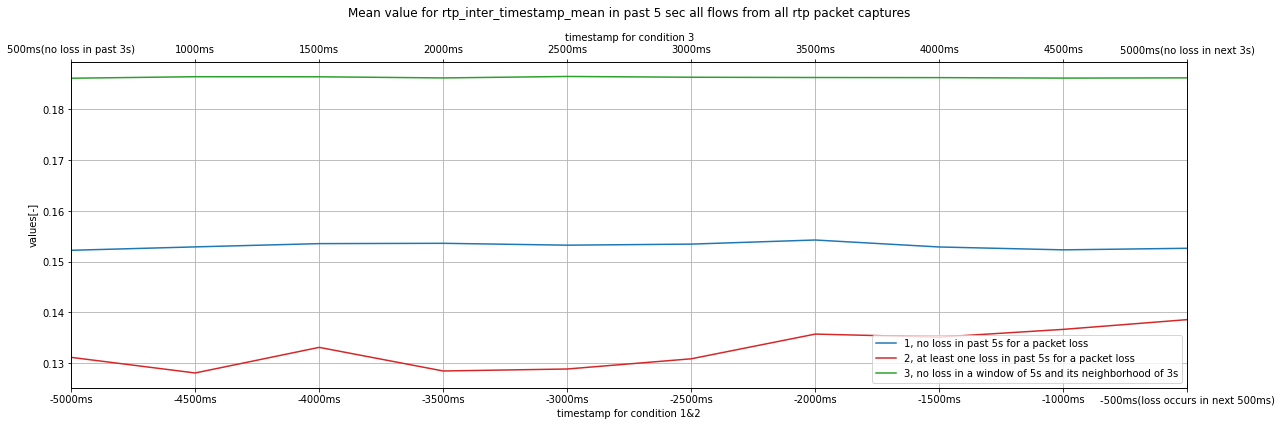

rtp_marker_sum_check


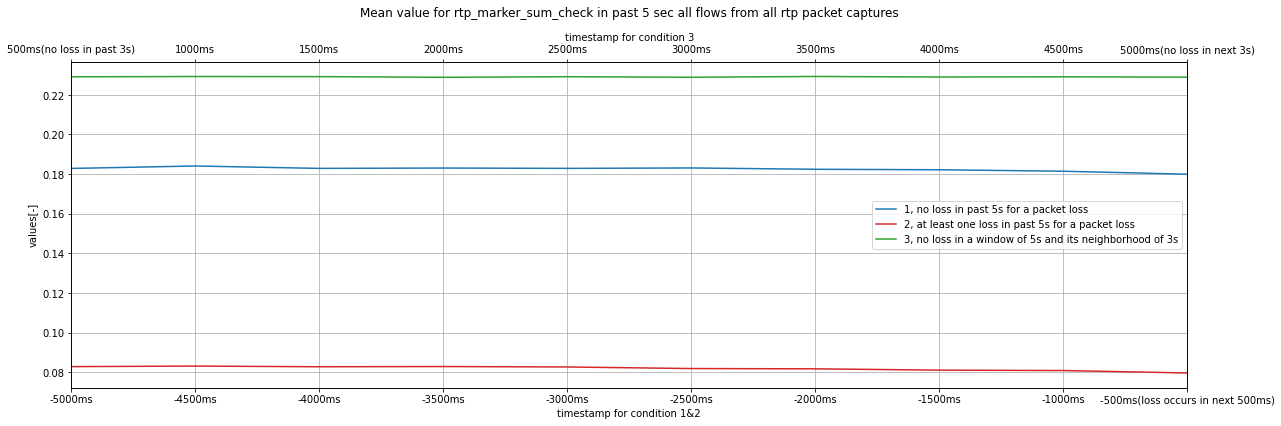

inter_time_sequence_std


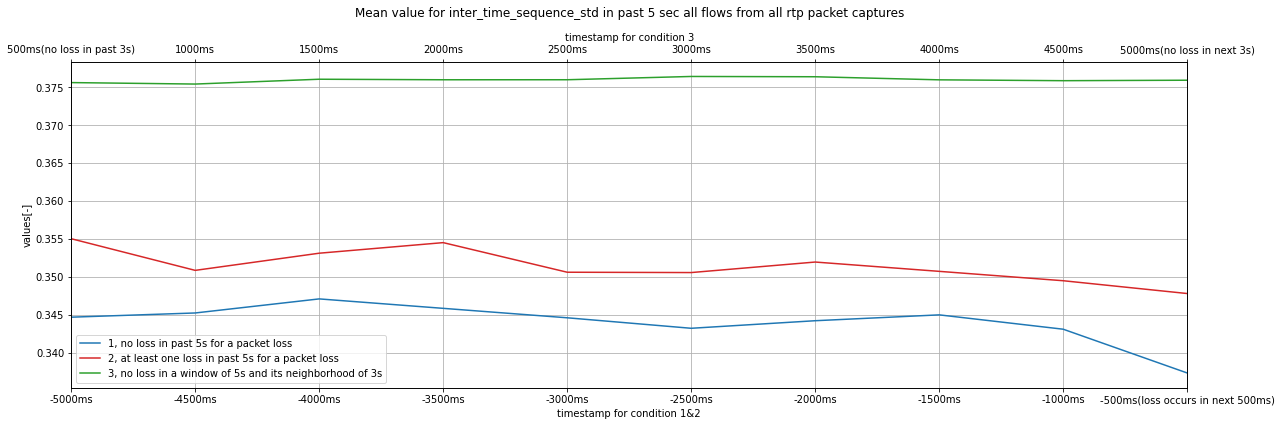

inter_time_sequence_mean


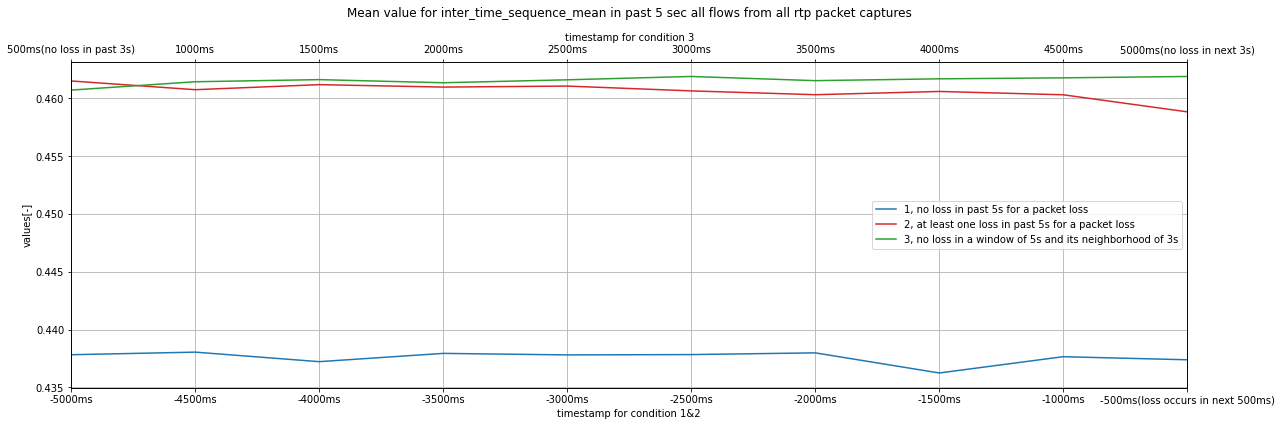

inter_time_sequence_min


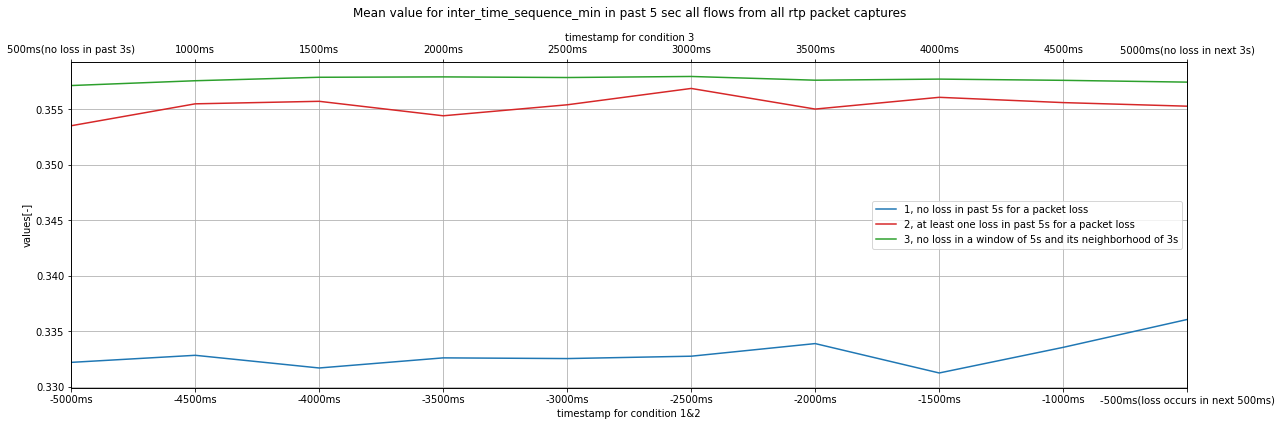

inter_time_sequence_max


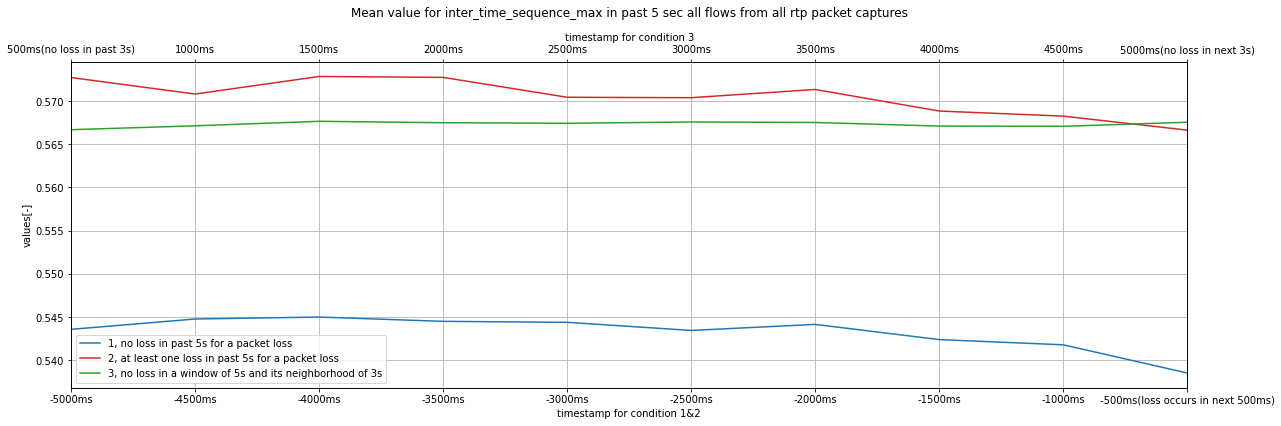

inter_time_sequence_count


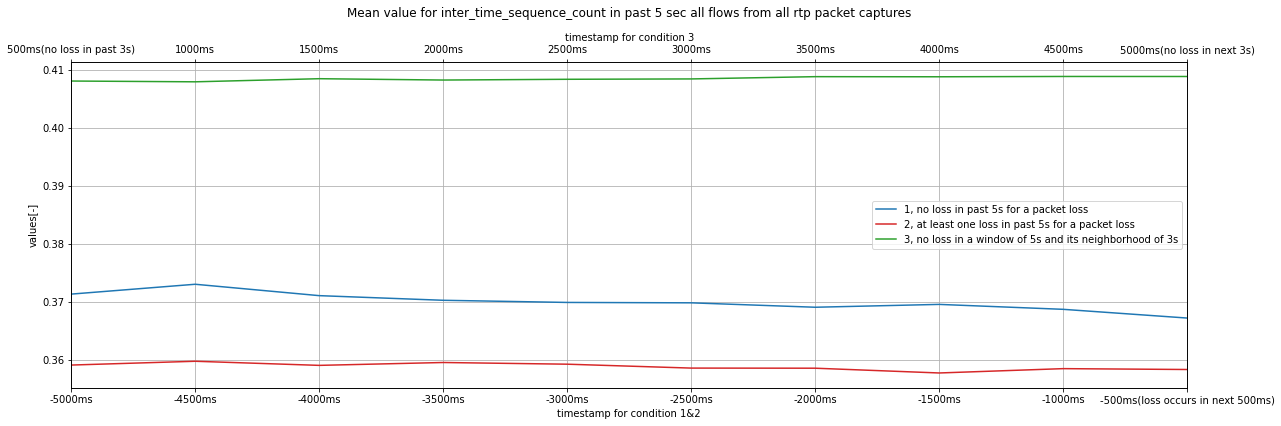

inter_time_sequence_kurtosis


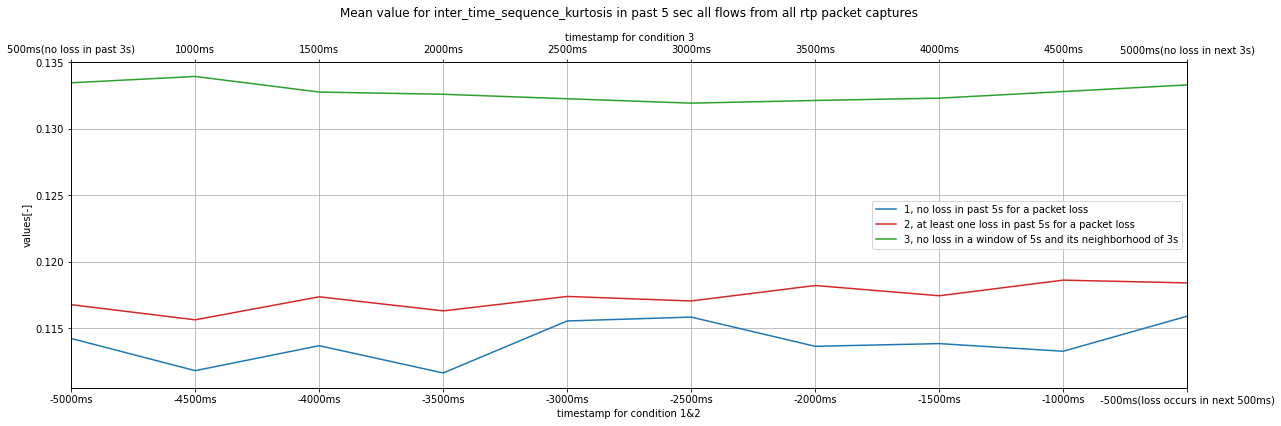

inter_time_sequence_skew


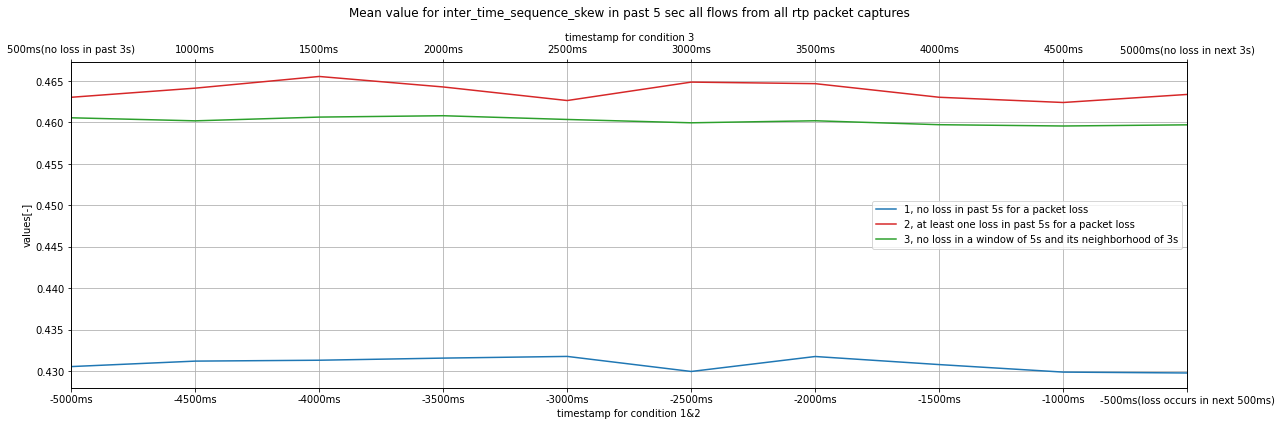

inter_time_sequence_moment3


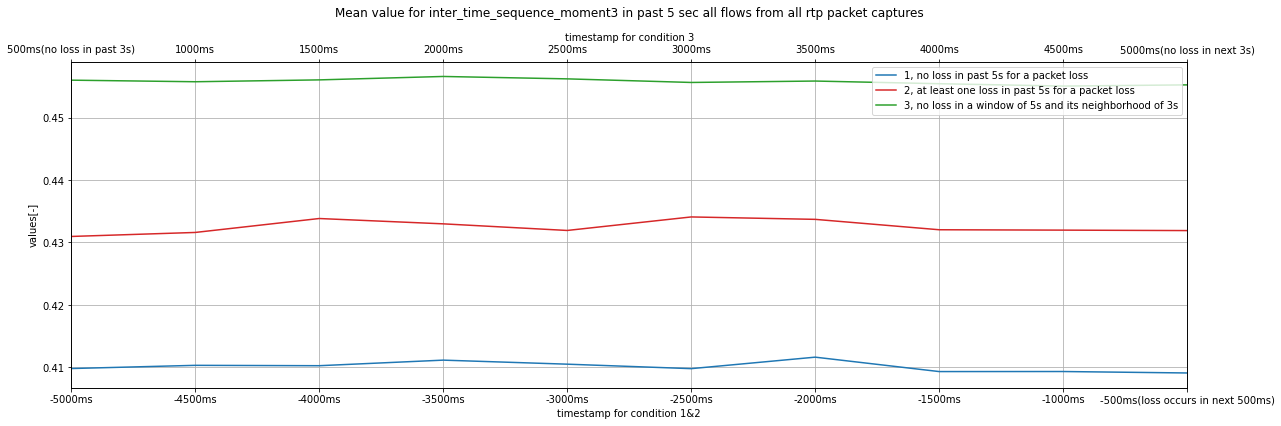

inter_time_sequence_moment4


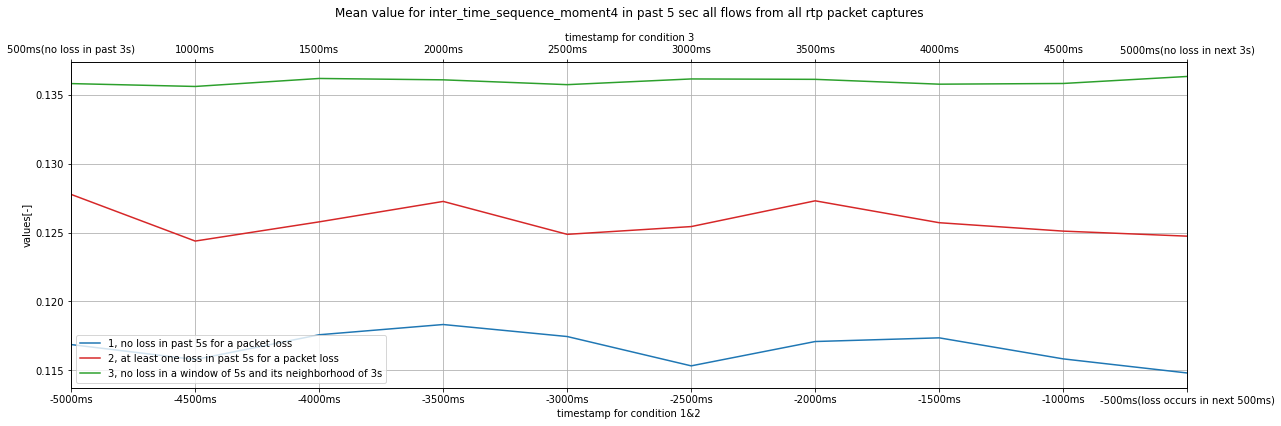

inter_time_sequence_max_min_diff


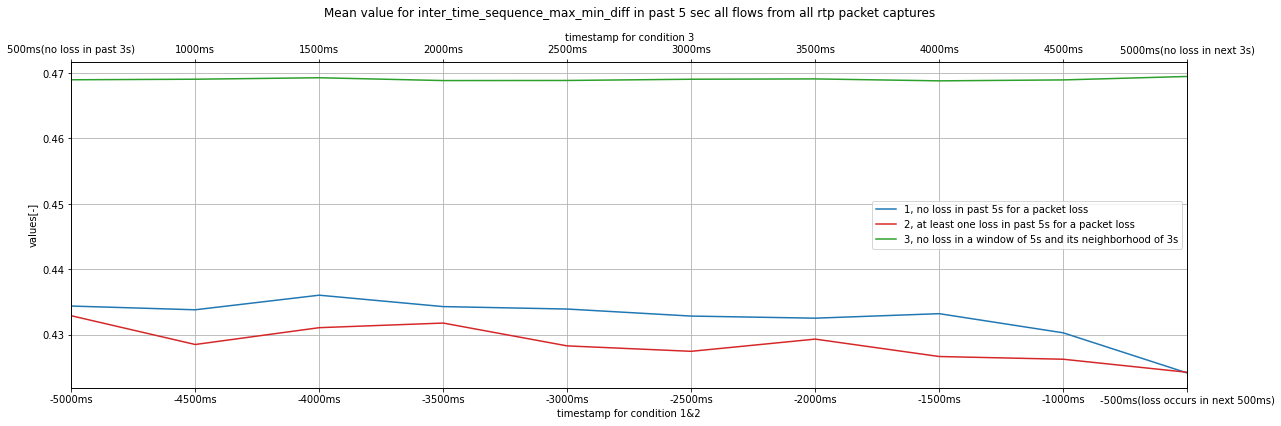

inter_time_sequence_max_min_R


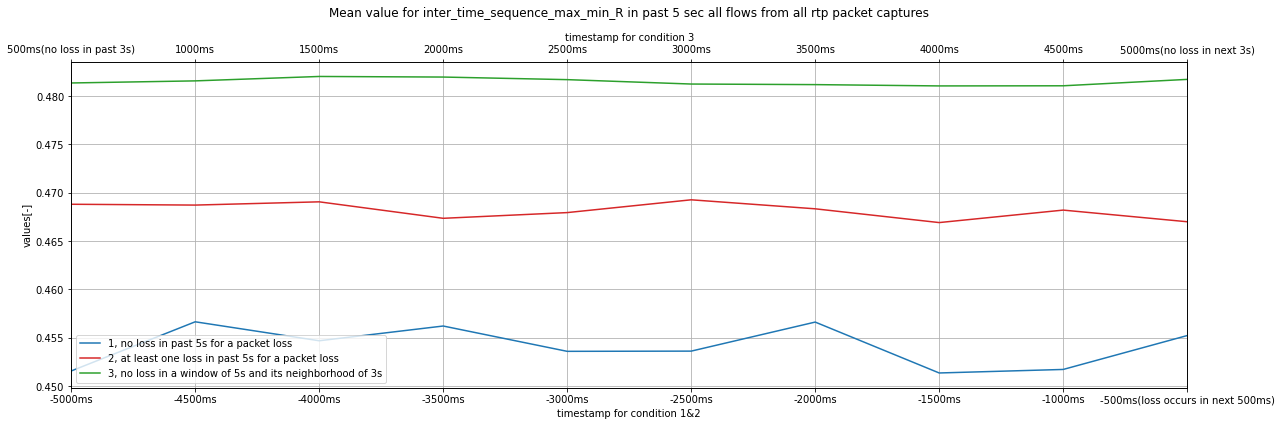

inter_time_sequence_min_max_R


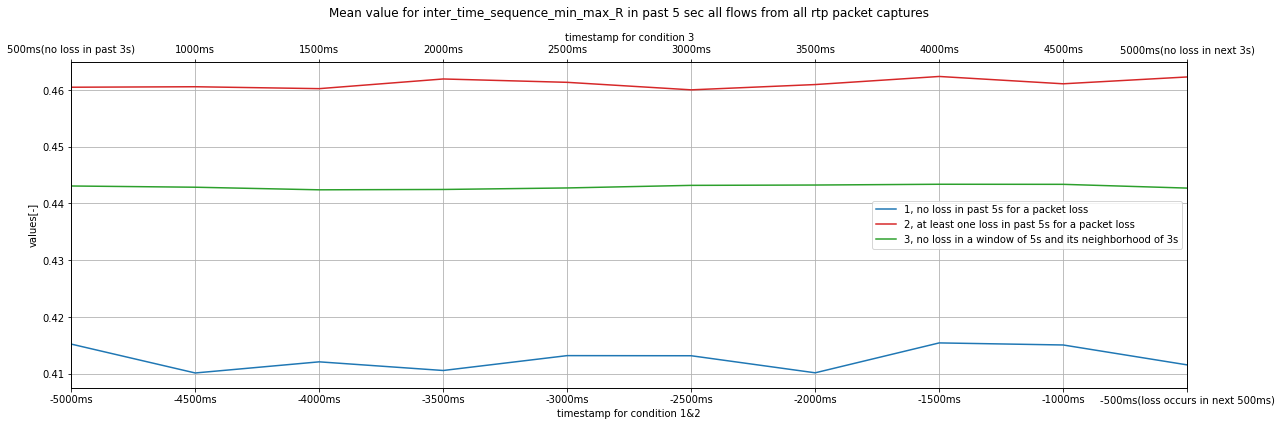

inter_time_sequence_len_unique_percent


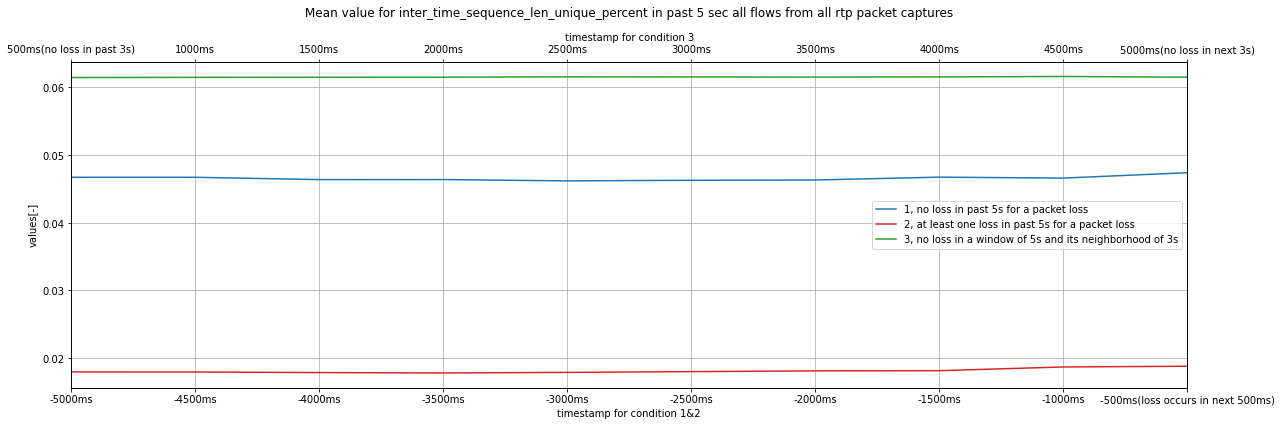

inter_time_sequence_max_value_count_percent


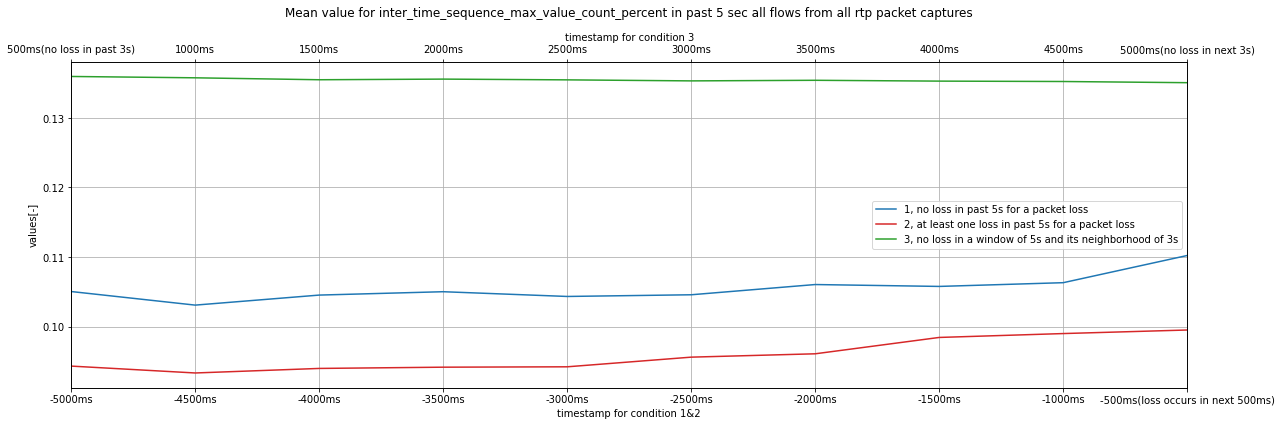

In [12]:
# keep outputing plots

## The followings are better plots

In [7]:
# only plot those with obvious trends and there's no correlation among them

selected_features_list_removing_correlation = [
    'interarrival_std',
    'interarrival_min',
    'interarrival_max',
    'interarrival_skew',
    'interarrival_moment4',
    'interarrival_max_min_R',
    'interarrival_max_value_count_percent',
    'len_udp_moment4',
    'len_udp_max_min_diff',
    'len_udp_max_value_count_percent',
    'inter_time_sequence_std'
]

color_for_plot_list = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'black', 'b', 'm', 'g']

interarrival_std


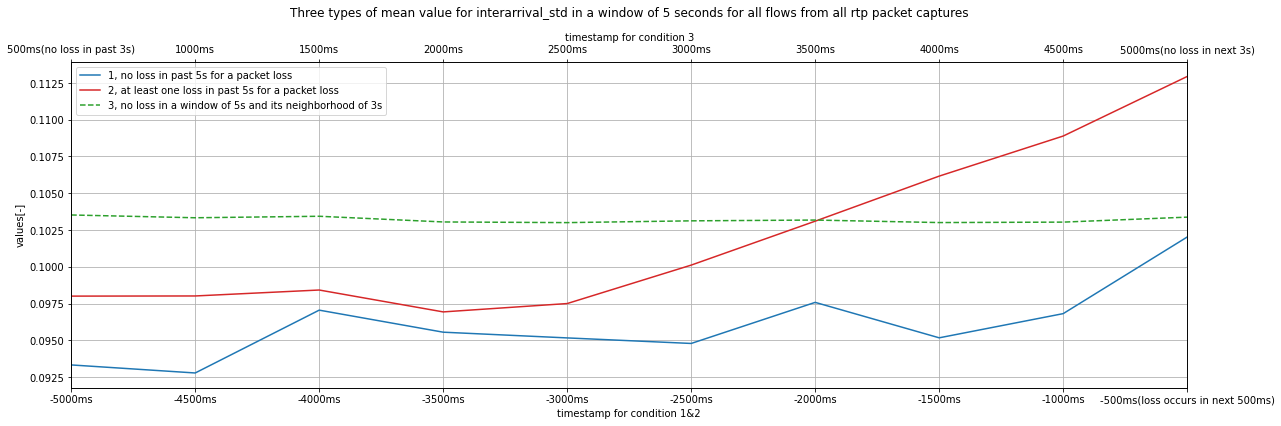

interarrival_min


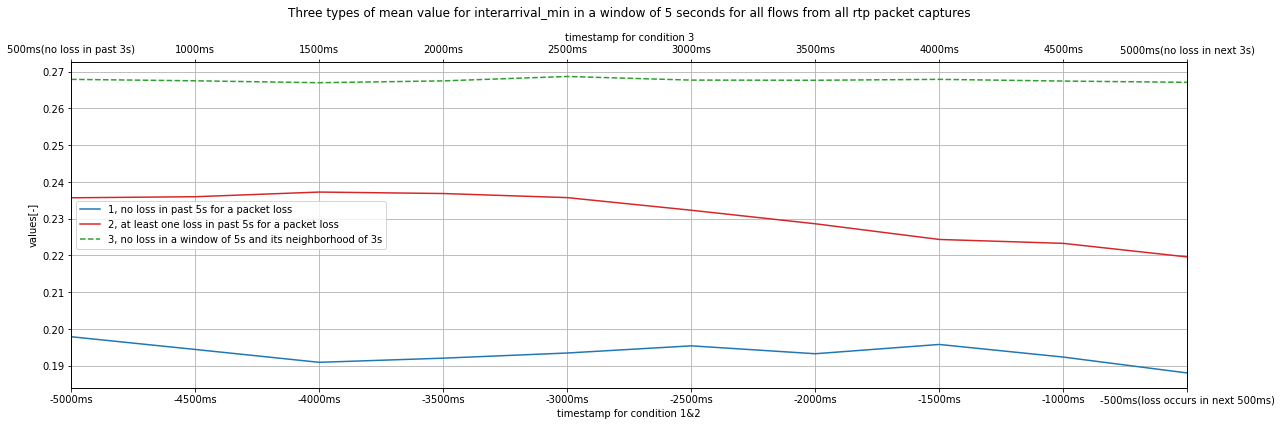

interarrival_max


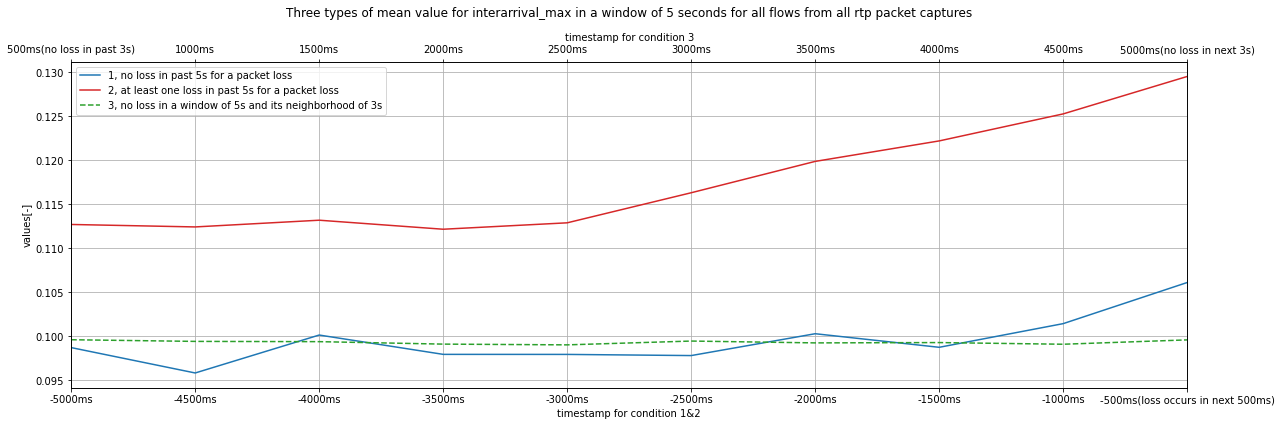

interarrival_skew


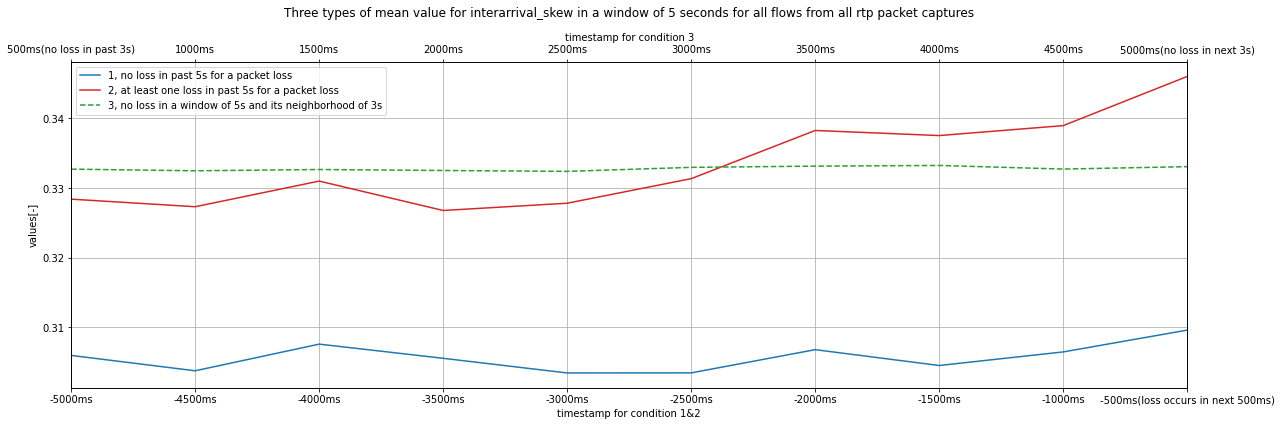

interarrival_moment4


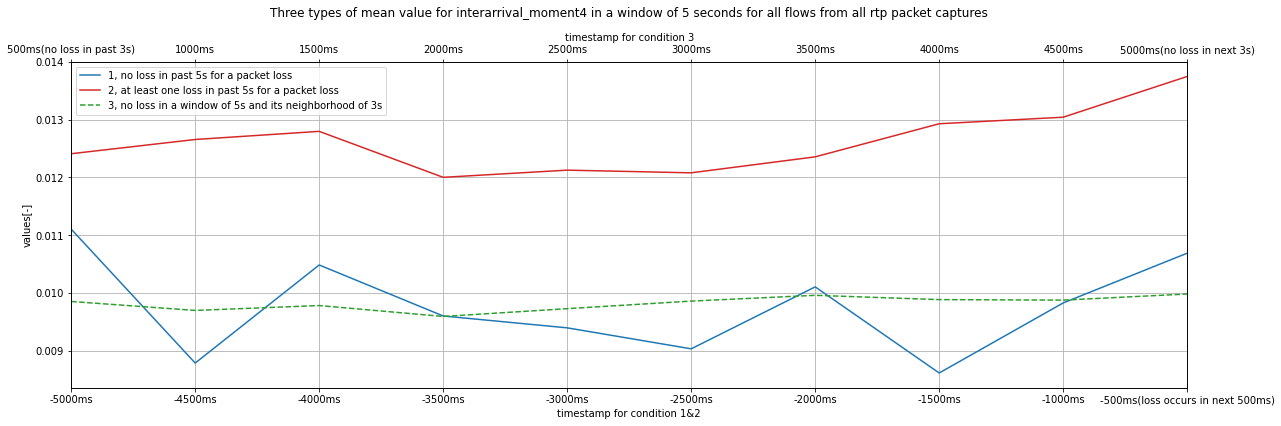

interarrival_max_min_R


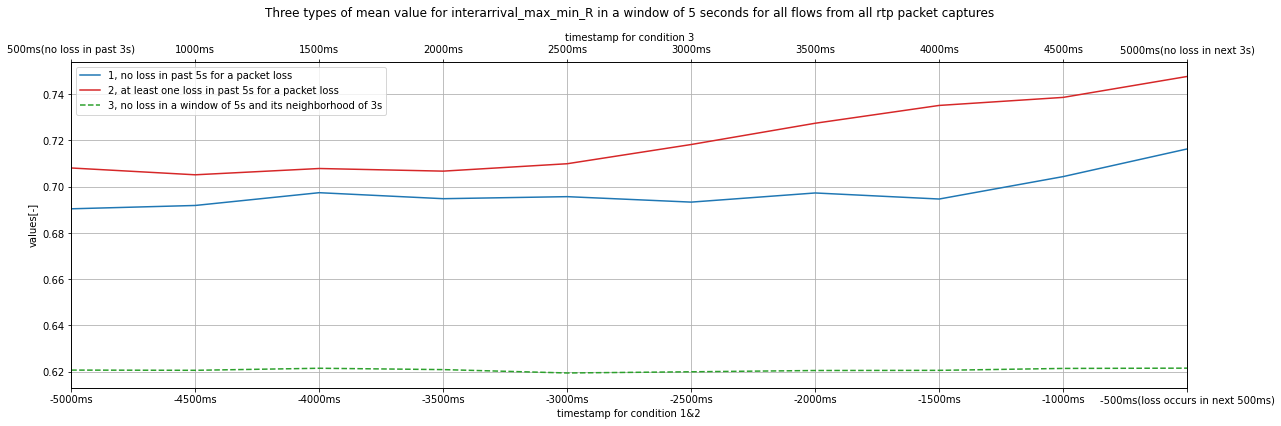

interarrival_max_value_count_percent


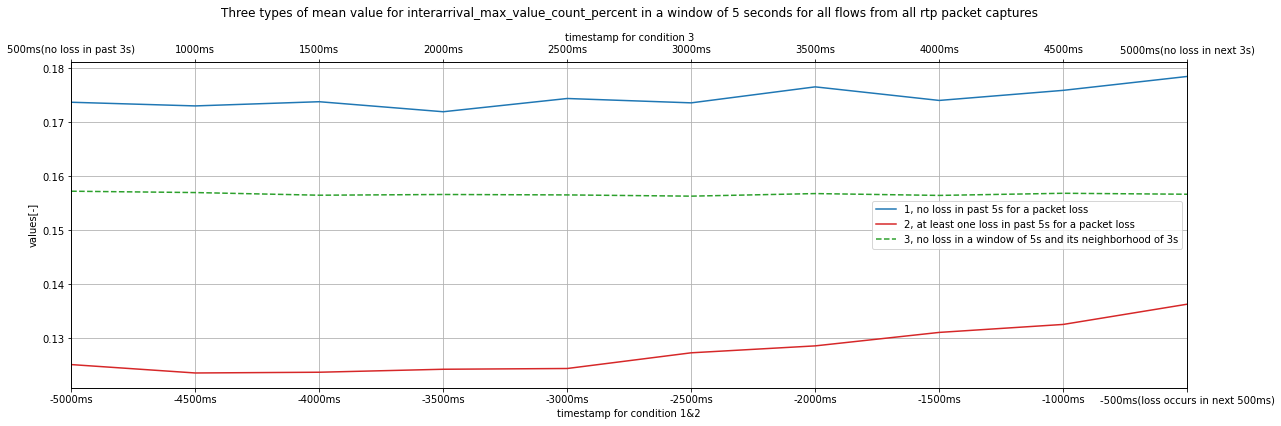

len_udp_moment4


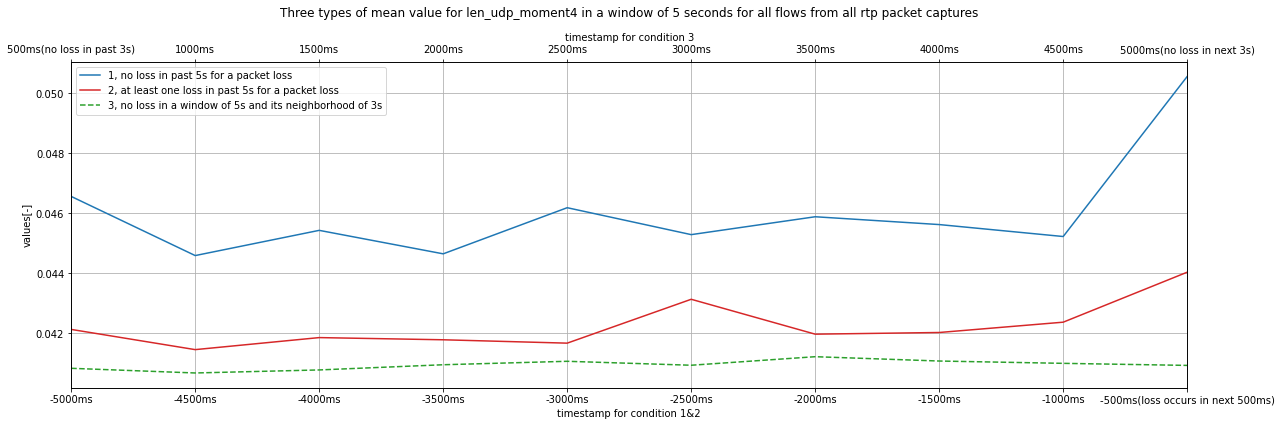

len_udp_max_min_diff


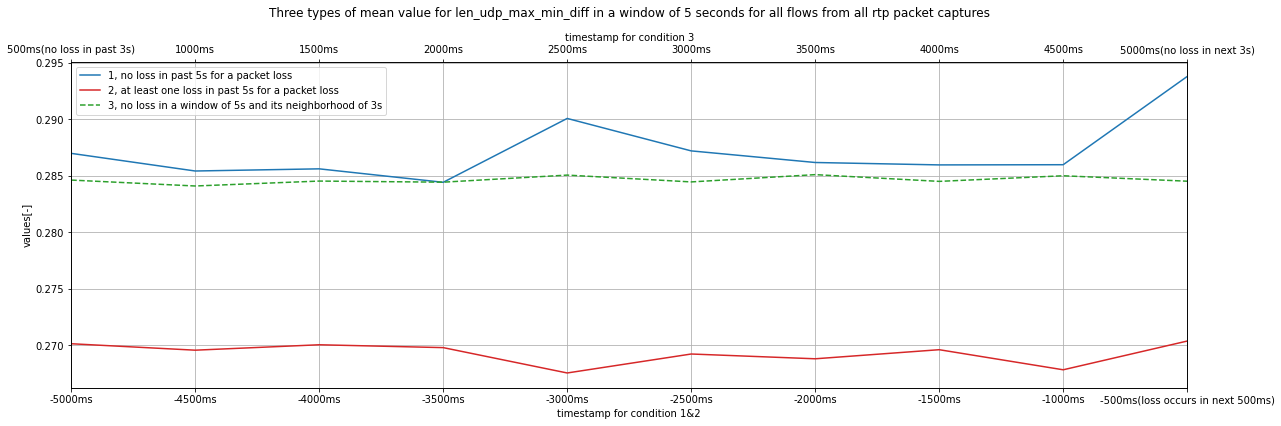

len_udp_max_value_count_percent


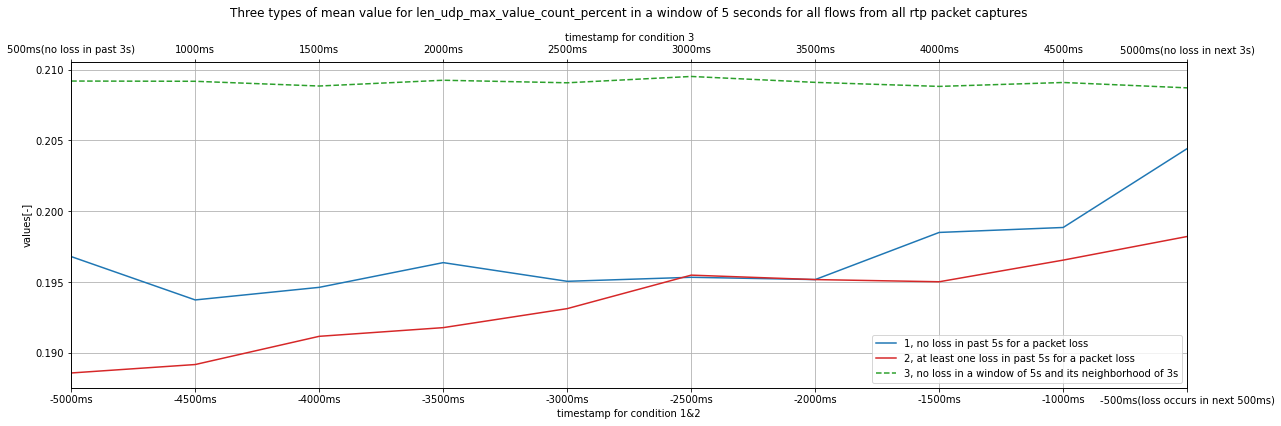

inter_time_sequence_std


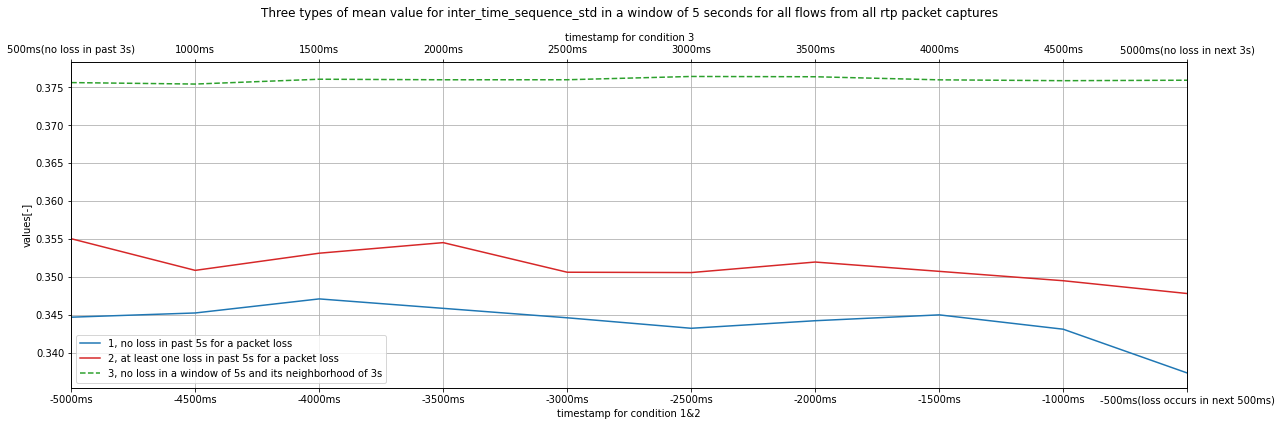

In [11]:
# check the trending of certain feature in 5s
# condition 1: no loss in past 5s for a loss;
# condition 2: at least one loss in past 5s for a loss;
# condition 3: consecutive 5s with no loss and in its neighborhood of 3s, there's also no loss.

for feature in selected_features_list_removing_correlation:
    print(feature)
    
    result_1 = {} # condition 1
    result_2 = {} # condition 2
    result_3 = {} # condition 3
    for i in range(window_size, 0, -1):
        result_1[str(i)] = []
        result_2[str(i)] = []
        result_3[str(i)] = []
        
    for df_ in df_total_final:
        df_temp = copy.deepcopy(df_)
        loss_index_list = df_temp[df_temp['lossOrNot'] > 0].index
        loss_index_list = [x for x in loss_index_list if x>9] # if the first loss is within the first 5s, we can only use it as feature but not output
        
        # condition 1 and 2:
        if len(loss_index_list) != 0:
            loss_index_list_no_consecutive = []
            loss_index_list_with_consecutive = []
            
            # if there are more than 1 losses
            if len(loss_index_list) > 1:
                for i in range(len(loss_index_list)-1, 0, -1):
                    if (loss_index_list[i] - loss_index_list[i-1]) not in dist_list:
                        loss_index_list_no_consecutive.append(loss_index_list[i])
                    elif (loss_index_list[i] - loss_index_list[i-1]) in dist_list:
                        loss_index_list_with_consecutive.append(loss_index_list[i])
                loss_index_list_no_consecutive.append(loss_index_list[0])
                
            # if there's only one loss, put it directly into loss_index_list_no_consecutive
            else:
                loss_index_list_no_consecutive.append(loss_index_list[0])

            for i in range(window_size, 0, -1):
                values_1 = df_temp.iloc[[x - i for x in loss_index_list_no_consecutive]][feature].tolist()
                result_1[str(i)].extend(values_1)
                values_2 = df_temp.iloc[[x - i for x in loss_index_list_with_consecutive]][feature].tolist()
                result_2[str(i)].extend(values_2)
                
        # condition 3:
        if df_temp.shape[0] >= 22: 
            for key, df_output in df_temp.groupby((df_temp['lossOrNot'].shift() != df_temp['lossOrNot']).cumsum()):
                df_output.reset_index(inplace=True)
                if df_output.iloc[0]['lossOrNot'] < 1 and df_output.shape[0] >= 22:
                    df_output = df_output.iloc[6:-6][:]
                    df_seg_list = [df_output.iloc[n:n+10, :] for n in range(0, len(df_output), 10)]
                    for df_seg in df_seg_list:
                        if df_seg.shape[0] == 10:
                            df_seg.reset_index(inplace=True)
                            for i in range(1,11):
                                result_3[str(i)].append(df_seg.iloc[i-1][feature])
                
    output_mean_1 = []
    output_std_1 = []
    output_mean_2 = []
    output_std_2 = []
    output_mean_3 = []
    output_std_3 = []
    for i in range(window_size, 0, -1):
        
        # result of condition 1
        temp = np.array(result_1[str(i)])
        temp = temp[~np.isnan(temp)]
        output_mean_1.append(temp.mean())
        output_std_1.append(np.std(temp))
        
        # result of condition 2
        temp = np.array(result_2[str(i)])
        temp = temp[~np.isnan(temp)]
        output_mean_2.append(temp.mean())
        output_std_2.append(np.std(temp))
        
        # result of condition 3
        temp = np.array(result_3[str(i)])
        temp = temp[~np.isnan(temp)]
        output_mean_3.append(temp.mean())
        output_std_3.append(np.std(temp))
        
    result_dict = {}
    result_dict['condition_1_mean'] = output_mean_1
    result_dict['condition_1_std'] = output_std_1
    result_dict['condition_2_mean'] = output_mean_2
    result_dict['condition_2_std'] = output_std_2
    result_dict['condition_3_mean'] = output_mean_3
    result_dict['condition_3_std'] = output_std_3
    
    with open(f'models/average_behavior_features/{feature}_dict.pickle', 'wb') as f:
        pickle.dump(result_dict, f)
        
    # visulization
    fig, axs = plt.subplots(1, figsize=(20,6), sharex=True)
    plt.title(f'Three types of mean value for {feature} in a window of {int(window_size/2)} seconds for all flows from all rtp packet captures', y=1.12)
    axs.plot(x_label_list, output_mean_1, color=color_for_plot_list[0], label='1, no loss in past 5s for a packet loss')
    axs.plot(x_label_list, output_mean_2, color=color_for_plot_list[3], label='2, at least one loss in past 5s for a packet loss')
    axs.plot(x_label_list, output_mean_3, color=color_for_plot_list[1], linestyle='--', label='3, no loss in a window of 5s and its neighborhood of 3s')
    axs.grid()
    axs.set_xlim(0, window_size-1)
    axs.legend()
    axs.set_xlabel('timestamp for condition 1&2')
    axs.set_ylabel('values[-]')
    axs2 = axs.twiny()
    axs2.set_xticks(axs.get_xticks())
    axs2.set_xbound(axs.get_xbound())
    axs2.set_xticklabels(x_label_list_plus)
    axs2.set_xlabel('timestamp for condition 3')
    plt.savefig(f'plots/{feature}.png', bbox_inches='tight')
    plt.show()